In [31]:
import tensorflow as tf
import numpy as np
import scipy

import cv2
import matplotlib.pyplot as plt
import numpy as np
import time
import glob, os, sys, gc
import skimage

plt.style.use('ggplot')
sys.path.insert(0,'..') # add parent directory to path
from prior_attention import build_prior_attentions
import utils
from config import Config

import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D, LSTM
from keras import optimizers
from keras.optimizers import Adam

# this is important to make sure the Config is reloaded when modified
%load_ext autoreload
%autoreload 2
# %pprint

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [32]:
dict(vars(Config))

{'__module__': 'config',
 'main_path': '/home/mikey/Data/POETdataset/PascalImages',
 'class_names': ['dog',
  'aeroplane',
  'boat',
  'bicycle',
  'cat',
  'cow',
  'diningtable',
  'horse',
  'motorbike',
  'sofa'],
 'IMG_SIZE': 480,
 'PATCH_WIDTH': 60,
 'SMALLER_IMG_SIZE': 150,
 'T': 64,
 'new_dir': 'soft_attention_features_60',
 'new_dir_img': 'soft_attention_images_60',
 'name_to_class_dict': {'dog': 0,
  'aeroplane': 1,
  'boat': 2,
  'bicycle': 3,
  'cat': 4,
  'cow': 5,
  'diningtable': 6,
  'horse': 7,
  'motorbike': 8,
  'sofa': 9},
 'train_ids': ['horse_2010_004477.jpg',
  'cat_2010_001351.jpg',
  'horse_2008_006434.jpg',
  'dog_2010_002586.jpg',
  'cat_2008_007239.jpg',
  'cat_2010_002305.jpg',
  'cat_2009_003419.jpg',
  'sofa_2008_004670.jpg',
  'cow_2009_003189.jpg',
  'dog_2010_002808.jpg',
  'horse_2009_000409.jpg',
  'diningtable_2010_004361.jpg',
  'dog_2009_001535.jpg',
  'cat_2011_000973.jpg',
  'cow_2010_001694.jpg',
  'sofa_2011_001192.jpg',
  'cat_2009_001037.jpg

In [33]:
main_path = Config.main_path
class_names = Config.class_names
IMG_SIZE = Config.IMG_SIZE
PATCH_WIDTH = Config.PATCH_WIDTH
SMALLER_IMG_SIZE = Config.SMALLER_IMG_SIZE
T = Config.T
new_dir = Config.new_dir
new_dir_img = Config.new_dir_img
name_to_class_dict = Config.name_to_class_dict
train_ids, test_ids = Config.train_ids, Config.test_ids

In [57]:
def load_data(mode):
    X = []
    y = []
    org_images = []
    all_ids = []
    for class_name, class_number in name_to_class_dict.items():
        classfeatures_path = os.path.abspath(os.path.join('.', new_dir, class_name + '_' + mode + '_features.pkl'))
        classimages_path = os.path.abspath(os.path.join('.', new_dir_img, class_name + '_' + mode + '.pkl'))
        print(classfeatures_path)

        features = np.asarray(utils.load_object(classfeatures_path).reshape(-1,T,2048), dtype=np.float32)
        images = np.asarray(utils.load_object(classimages_path), dtype=np.float32)
        ids = utils.load_object(new_dir + os.path.sep + class_name + '_'+mode+'_names.pkl')
        org_images.append(images)

        print(features.shape)
        X.append(features)
        y.append([class_number] * features.shape[0])
        all_ids.append(ids)

    X = np.concatenate(X)
    y = np.concatenate(y)
    y = keras.utils.to_categorical(y)
    ids = np.concatenate(all_ids)
    org_images = np.concatenate(org_images)
    return X, y, org_images, ids
    
X_train, y_train, images_train, train_ids = load_data(mode='train')
X_test, y_test, images_test, test_ids = load_data(mode='test')

X_train.shape, y_train.shape, images_train.shape, X_test.shape, y_test.shape, images_test.shape

/home/mikey/Repos/visual-attention-cnn-and-eye-tracking/soft_attention_model/soft_attention_features_60/dog_train_features.pkl
(1128, 64, 2048)
/home/mikey/Repos/visual-attention-cnn-and-eye-tracking/soft_attention_model/soft_attention_features_60/aeroplane_train_features.pkl
(599, 64, 2048)
/home/mikey/Repos/visual-attention-cnn-and-eye-tracking/soft_attention_model/soft_attention_features_60/boat_train_features.pkl
(454, 64, 2048)
/home/mikey/Repos/visual-attention-cnn-and-eye-tracking/soft_attention_model/soft_attention_features_60/bicycle_train_features.pkl
(480, 64, 2048)
/home/mikey/Repos/visual-attention-cnn-and-eye-tracking/soft_attention_model/soft_attention_features_60/cat_train_features.pkl
(943, 64, 2048)
/home/mikey/Repos/visual-attention-cnn-and-eye-tracking/soft_attention_model/soft_attention_features_60/cow_train_features.pkl
(265, 64, 2048)
/home/mikey/Repos/visual-attention-cnn-and-eye-tracking/soft_attention_model/soft_attention_features_60/diningtable_train_features

((5517, 64, 2048),
 (5517, 10),
 (5517, 150, 150, 3),
 (614, 64, 2048),
 (614, 10),
 (614, 150, 150, 3))

In [5]:
tf.reset_default_graph()

n_epochs = 100
batch_size = 32
T = X_train.shape[1]
lstm_time = 3 #analogous to fixations ?
regularize_attention = True
pretrain_attention = False
prior_attentions_train = build_prior_attentions(utils.load_object('../train_fix.pkl'), T, lstm_time, gauss_sigma=None)
prior_attentions_test = build_prior_attentions(utils.load_object('../test_fix.pkl'), T, lstm_time, gauss_sigma=None)

               
X_input = tf.placeholder(tf.float32, [None, T, 2048], name='X')
prior_attentions_input = tf.placeholder(tf.float32, [None, lstm_time, T])
labels = tf.placeholder(tf.int32, [None, y_train.shape[1]], name='labels')

rnn_units = 32

# c,h = utils._get_initial_lstm(X_input[:,:,:], H=rnn_units)

context = tf.layers.dense(tf.reshape(X_input, shape=(-1, T*2048)), rnn_units, activation='tanh')
c = tf.layers.dense(tf.reshape(X_input, shape=(-1, T*2048)), rnn_units, activation='tanh')
h = tf.layers.dense(tf.reshape(X_input, shape=(-1, T*2048)), rnn_units, activation='tanh')
# context = tf.layers.dropout(context, rate=0.1)

lstm_cell = tf.nn.rnn_cell.BasicLSTMCell(num_units=rnn_units)

contexts = []
attentions = []

att_input = tf.nn.tanh(X_input) # squeeze features from Resnet into same scale as context

AttentionDense = tf.layers.Dense(T, activation='tanh')

kernel_reg, activity_reg = None, None
if regularize_attention:
    kernel_reg, activity_reg = (tf.contrib.layers.l2_regularizer(scale=.0005),
                                tf.contrib.layers.l2_regularizer(scale=.0005))

ContextDense = tf.layers.Dense(2048, activation='tanh',
                              kernel_regularizer=kernel_reg,
                              activity_regularizer=activity_reg)
for t in range(lstm_time):
    # encoded lstm context to a specific size 
    context_transformed = ContextDense(context)
#     context_transformed = tf.layers.dropout(context_transformed, rate=0.1)
    
    # how lstm context and patch info relate
    att = tf.einsum('bi,bti->bt', context_transformed, att_input)
#     att_input = tf.layers.dense(tf.reshape(X_input, shape=(-1, T*2048)), T, activation='tanh')

#     att = AttentionDense(tf.concat([context, att_input], axis=1))
    att = tf.nn.softmax(att)
    
    lstm_input = tf.einsum('bt,bti->bi', att, X_input)
    
    context, (c, h) = lstm_cell(inputs=lstm_input, state=[c, h])
    context = tf.layers.dropout(context, rate=0.5)
    contexts.append(context)
    attentions.append(att)
    
all_attentions_tensor = tf.transpose(tf.stack(attentions), [1,0,2])
attention_loss = tf.reduce_mean(tf.abs(tf.exp(tf.abs(all_attentions_tensor - tf.nn.softmax(prior_attentions_input))) - 1))
attention_loss = tf.reduce_mean(tf.abs(all_attentions_tensor - (prior_attentions_input)))

Dense = tf.layers.Dense(units=32, activation=tf.nn.relu)
Logits = tf.layers.Dense(units=y_train.shape[1])
probabilities_list = []
for context in contexts:
    dense = Dense(context)
    dense = tf.layers.dropout(dense, rate=0.7)

    # Logits Layer
    logits = Logits(dense)
    logits = tf.layers.dropout(logits, rate=0.7)

    classes = tf.argmax(logits, axis=1)
    probabilites = tf.nn.softmax(logits)
    probabilities_list.append(probabilites)

loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=labels, logits=logits))
l2_loss = tf.losses.get_regularization_loss()
loss += l2_loss

regular_loss_multiplier = tf.placeholder_with_default(1.0, shape=(), name='regular_loss_multiplier')
attention_loss_multiplier = tf.placeholder_with_default(0., shape=(), name='attention_loss_multiplier')

final_loss = regular_loss_multiplier * loss + attention_loss_multiplier * attention_loss

learning_rate = tf.placeholder(tf.float32, name='learning_rate')

optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train_op = optimizer.minimize(
    loss=final_loss,
    global_step=tf.train.get_global_step()
)

accuracy = tf.reduce_mean(tf.cast(tf.equal(classes, tf.argmax(labels, 1)), tf.float32))

init = tf.group(tf.global_variables_initializer(), tf.local_variables_initializer())

Instructions for updating:
This class is deprecated, please use tf.nn.rnn_cell.LSTMCell, which supports all the feature this cell currently has. Please replace the existing code with tf.nn.rnn_cell.LSTMCell(name='basic_lstm_cell').


Crucial points for high accuracy:
- regularization on attention
- shuffle after every epoch
- lstm time doesn't matter much (run experiments)
- some dropout to make sure it isn't stuck in local minima

In [6]:
saver = tf.train.Saver(max_to_keep=1)
with tf.Session() as sess:
    sess.run(init)
    
    training_attention = pretrain_attention
    learning_rate_ = 0.0001
    if training_attention:
        learning_rate_ = 0.00001
    
    changed_learning_rate = False
    train_acc_list = []
    acc_list = []
    for epoch in range(n_epochs):
        if training_attention: # training attention
            att_loss_multiplier_value = 1.
            regular_loss_multiplier_value = 0.
        elif pretrain_attention: # switched from training attention to not training
            att_loss_multiplier_value = 10.
            regular_loss_multiplier_value += .1
            if regular_loss_multiplier_value > 1:
                regular_loss_multiplier_value = 1.
                att_loss_multiplier_value = 0.
        else: # wasn't training attention in the first place
            att_loss_multiplier_value = 0.
            regular_loss_multiplier_value = 1.
            
        print("Epoch:", epoch)
        train_acc = []
        att_losses = []
        for b in range(0, X_train.shape[0], batch_size):
            _, acc, loss_, att_loss_ = sess.run([train_op, accuracy, final_loss, attention_loss], feed_dict={
                                                            X_input: X_train[b:b+batch_size],
                                                            prior_attentions_input: prior_attentions_train[b:b+batch_size],
                                                            labels: y_train[b:b+batch_size],
                                                            learning_rate: learning_rate_,
                                                            attention_loss_multiplier: att_loss_multiplier_value,
                                                            regular_loss_multiplier: regular_loss_multiplier_value
                                                        })
            train_acc.append(acc)
            att_losses.append(att_loss_)
            
        # reshuffle after every epoch
        if not training_attention:
#             X_train, y_train, prior_attentions, images_train = \
#                 utils.unison_shuffled_copies([X_train, y_train, prior_attentions_train, images_train])
            
            acc, context_, atts_, test_proba_, probabilities_list_, att_loss_test = \
                sess.run([accuracy,
                          context, all_attentions_tensor, probabilites,
                          probabilities_list,
                         attention_loss], 
                         feed_dict={
                                    X_input: X_test[:],
                                    labels: y_test[:],
                                    prior_attentions_input: prior_attentions_test[:],
                                    })
            if acc > 0.8 and not changed_learning_rate:
                learning_rate_ = learning_rate_ / 10.
                changed_learning_rate = True
                print("Adjusted learning rate to", learning_rate_)

            if acc > 0.97:
                break
        else:
            acc, context_, atts_, test_proba_, probabilities_list_, att_loss_test = \
                sess.run([accuracy,
                          context, all_attentions_tensor, probabilites,
                          probabilities_list,
                         attention_loss], 
                         feed_dict={
                                    X_input: X_test[:],
                                    labels: y_test[:],
                                    prior_attentions_input: prior_attentions_test[:],
                                    })
                     
        print("Train:", np.mean(train_acc))
        print("Test:", acc)
        print("Attention loss", np.mean(att_losses))
        print("Attention loss test", att_loss_test)
        train_acc_list.append(np.mean(train_acc))
        acc_list.append(acc)
        train_acc = []
        att_losses = []
        
        if len(acc_list) > 1 and acc > np.max(acc_list[:-1]):
            saver.save(sess, './checkpoint' + str(Config.PATCH_WIDTH) + '/model-with-attention')
        
#         0.0303
#         0.111
        if training_attention and att_loss_test < 0.05:
            training_attention = False
            print("Done training prior attention")
            learning_rate_ = learning_rate_ * 10
#             break
#         print(atts_[0])

Epoch: 0
Train: 0.1517341
Test: 0.078175895
Attention loss 0.03077884
Attention loss test 0.030974768
Epoch: 1
Train: 0.1013367
Test: 0.23289903
Attention loss 0.030678479
Attention loss test 0.030613996
Epoch: 2
Train: 0.2829591
Test: 0.34527686
Attention loss 0.030677583
Attention loss test 0.03041676
Epoch: 3
Train: 0.32143453
Test: 0.4136808
Attention loss 0.03061723
Attention loss test 0.03056331
Epoch: 4
Train: 0.33127224
Test: 0.4820847
Attention loss 0.030621203
Attention loss test 0.030466294
Epoch: 5
Train: 0.43937585
Test: 0.51302934
Attention loss 0.030612582
Attention loss test 0.03048967
Epoch: 6
Train: 0.49202424
Test: 0.5635179
Attention loss 0.030615503
Attention loss test 0.030551463
Epoch: 7
Train: 0.51785517
Test: 0.60749185
Attention loss 0.030626051
Attention loss test 0.030513262
Epoch: 8
Train: 0.58585757
Test: 0.63355047
Attention loss 0.03063577
Attention loss test 0.030491209
Epoch: 9
Train: 0.6240829
Test: 0.65798044
Attention loss 0.030635167
Attention loss

KeyboardInterrupt: 

In [35]:
saver = tf.train.Saver(max_to_keep=1)
with tf.Session() as sess:
    sess.run(init)
#     new_saver = tf.train.import_meta_graph('./checkpoint/model-with-attention.meta')
    saver.restore(sess, tf.train.latest_checkpoint('./checkpoint' + str(Config.PATCH_WIDTH)))

    acc, context_, atts_, test_proba_, probabilities_list_, att_loss_test = \
        sess.run([accuracy,
                  context, all_attentions_tensor, probabilites,
                  probabilities_list,
                 attention_loss], 
                 feed_dict={
                            X_input: X_test,
                            labels: y_test,
                            prior_attentions_input: prior_attentions_test,
                            })
    print("Test:", acc)
    print("Attention loss", att_loss_test)

INFO:tensorflow:Restoring parameters from ./checkpoint60/model-with-attention
Test: 0.8013029
Attention loss 0.030403767


In [36]:
np.array(context_).shape, np.array(atts_).shape

((614, 32), (614, 3, 64))

In [37]:
atts_ = np.array(atts_)
images_test = np.array(images_test)
probabilities_list_ = np.array(probabilities_list_)

atts_.shape

(614, 3, 64)

In [38]:
unique, counts = np.unique(np.argmax(y_test, axis=-1), return_counts=True)
class_to_name_dict = {v:k for k,v in name_to_class_dict.items()}
unique = np.array([class_to_name_dict[u] for u in unique])

np.asarray((unique, counts)).T

array([['dog', '126'],
       ['aeroplane', '67'],
       ['boat', '50'],
       ['bicycle', '53'],
       ['cat', '105'],
       ['cow', '30'],
       ['diningtable', '47'],
       ['horse', '48'],
       ['motorbike', '50'],
       ['sofa', '38']], dtype='<U21')

In [39]:
unique, counts = np.unique(np.argmax(test_proba_, axis=-1), return_counts=True)
class_to_name_dict = {v:k for k,v in name_to_class_dict.items()}
unique = np.array([class_to_name_dict[u] for u in unique])

np.asarray((unique, counts)).T

array([['dog', '105'],
       ['aeroplane', '63'],
       ['boat', '54'],
       ['bicycle', '47'],
       ['cat', '109'],
       ['cow', '17'],
       ['diningtable', '42'],
       ['horse', '69'],
       ['motorbike', '62'],
       ['sofa', '46']], dtype='<U21')

In [40]:
from scipy import signal
from scipy import ndimage

def get_attention_result(img, attention, patches_n, img_size, patch_width, scale = 8, gauss_sigma=None):
    result = np.zeros_like(img)
    for attended_patch_n in range(patches_n):
        att_prob = attention[attended_patch_n]

        row = int(attended_patch_n/(img_size/patch_width))
        col = int(attended_patch_n%(img_size/patch_width))

        from_y = row*patch_width
        to_y = from_y+patch_width

        from_x = col*patch_width
        to_x = from_x+patch_width
        
        result[from_y:to_y, from_x:to_x, :] = np.ones_like(result[from_x:to_x,from_y:to_y,:]) * 255 * att_prob
    
    result = result / 255.
    if gauss_sigma:
        result = ndimage.gaussian_filter(result, sigma=gauss_sigma)
    
    result = result * scale
    result[result > 1] = 1
    
    img = img / 255.
    return utils.normalize((scale/20) * img + result), result

In [41]:
name_to_fix_test = {name:fix for fix, name in zip(utils.load_object('../test_fix.pkl'), utils.load_object('../test_ids.pkl'))}

In [42]:
probabilities_list_.shape

(3, 614, 10)

In [43]:
probabilities_list_ = np.transpose(probabilities_list_, [1,0,2])

In [44]:
human_heatmaps = np.load('../cam/heatmaps_resized.npy').tolist()

In [45]:
class_to_name_dict

{0: 'dog',
 1: 'aeroplane',
 2: 'boat',
 3: 'bicycle',
 4: 'cat',
 5: 'cow',
 6: 'diningtable',
 7: 'horse',
 8: 'motorbike',
 9: 'sofa'}

In [64]:
from collections import Counter
counter_dict = {key: 0 for key in dict(Counter([el.split('_')[0] for el in np.array(test_ids)])).keys()}
counter_dict

{'dog': 0,
 'aeroplane': 0,
 'boat': 0,
 'bicycle': 0,
 'cat': 0,
 'cow': 0,
 'diningtable': 0,
 'horse': 0,
 'motorbike': 0,
 'sofa': 0}


  0%|          | 0/614 [00:00<?, ?it/s]

(614, 3, 10)
dog_2008_003665.jpg
[[0.5351     0.4592    ]
 [0.5301     0.43786667]]
sofa 0.12289877
diningtable 0.103183866
horse 0.10180444
cat 0.09828914
cow 0.09789315
bicycle 0.09720009
boat 0.09612838
aeroplane 0.09596992
dog 0.0957837
motorbike 0.090848565
(480, 480, 3)
0.030106856727288765
aeroplane 0.20316437
boat 0.12222095
dog 0.1104938
horse 0.10952695
sofa 0.09786659
cow 0.09566544
bicycle 0.07415032
motorbike 0.06882379
cat 0.068752155
diningtable 0.049335632
(480, 480, 3)
0.030652313005703036
dog 0.6277153
cat 0.13424954
horse 0.12171724
cow 0.086854324
sofa 0.013182838
diningtable 0.007527212
motorbike 0.004513552
boat 0.0024057368
bicycle 0.0015496614
aeroplane 0.00028451293
(480, 480, 3)
0.031069492393534404


/home/mikey/.local/lib/python3.6/site-packages/skimage/transform/_warps.py:24: UserWarning: The default multichannel argument (None) is deprecated.  Please specify either True or False explicitly.  multichannel will default to False starting with release 0.16.
  warn('The default multichannel argument (None) is deprecated.  Please '
/home/mikey/.local/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/mikey/.local/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


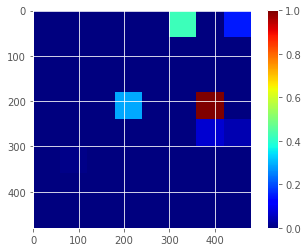

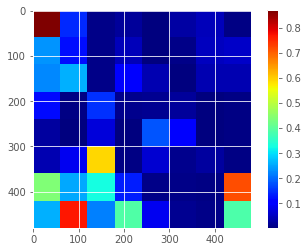

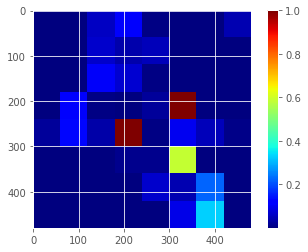


  0%|          | 1/614 [00:00<05:15,  1.94it/s]

dog_2011_001543.jpg
[[0.6614     0.39973333]
 [0.5477     0.42053333]]
sofa 0.120653816
horse 0.10175295
diningtable 0.10169232
bicycle 0.09856464
boat 0.09821884
aeroplane 0.09736609
cow 0.09716684
cat 0.09679294
dog 0.0961012
motorbike 0.09169041
(480, 480, 3)
0.031242087955634518
dog 0.12956104
sofa 0.1227167
boat 0.12205834
horse 0.121937424
cow 0.11842498
aeroplane 0.10065684
diningtable 0.08196125
cat 0.077993974
motorbike 0.065157324
bicycle 0.05953217
(480, 480, 3)
0.030741116164335835
cat 0.67189634
dog 0.26952815
cow 0.0273471
horse 0.022087788
diningtable 0.0037564728
sofa 0.002374566
boat 0.002049806
motorbike 0.00067645276
bicycle 0.0001841455
aeroplane 9.915589e-05
(480, 480, 3)
0.031079543530154297


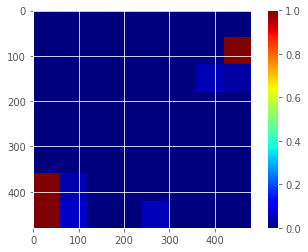

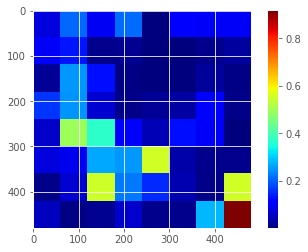

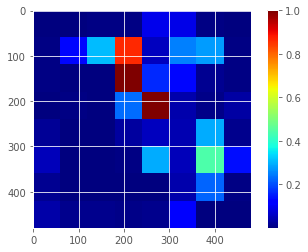


  0%|          | 2/614 [00:01<05:10,  1.97it/s]

dog_2010_000395.jpg
[[0.9696     0.09893333]
 [0.4387     0.37746667]
 [0.4038     0.57266667]
 [0.3676     0.52      ]]
horse 0.11501638
sofa 0.11251702
motorbike 0.11029803
dog 0.10833227
cow 0.10737878
cat 0.103707574
diningtable 0.094341666
bicycle 0.08414118
aeroplane 0.08279689
boat 0.08147017
(480, 480, 3)
0.03125000047744052
boat 0.13389908
dog 0.12973869
horse 0.11815935
sofa 0.110357136
cow 0.10839743
aeroplane 0.1082677
cat 0.07810292
diningtable 0.076384254
motorbike 0.07004577
bicycle 0.06664772
(480, 480, 3)
0.03122761501754212
cat 0.9729066
dog 0.014079208
horse 0.0068288413
cow 0.002747431
boat 0.0013318964
diningtable 0.00087404985
motorbike 0.00083246036
sofa 0.0002720311
bicycle 9.48513e-05
aeroplane 3.2588283e-05
(480, 480, 3)
0.028064724304613264


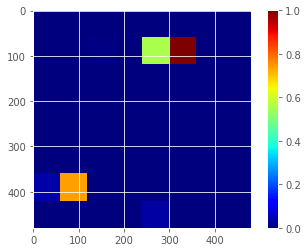

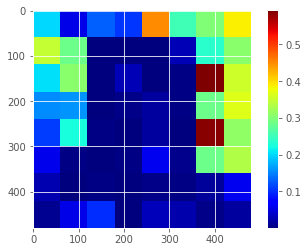

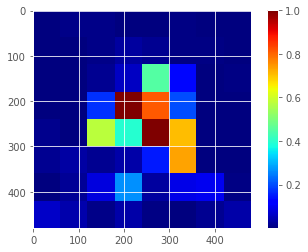


  0%|          | 3/614 [00:01<05:07,  1.99it/s]

dog_2008_004647.jpg
[[0.7155    0.403782 ]
 [0.1611    0.525574 ]
 [0.1136    0.5261276]]
boat 0.1332007
aeroplane 0.12077882
dog 0.10488604
bicycle 0.09956908
horse 0.09408947
motorbike 0.09326072
cat 0.09185759
cow 0.09137714
sofa 0.08878427
diningtable 0.082196206
(480, 480, 3)
0.0005767270010340851
dog 0.13808371
boat 0.13494459
aeroplane 0.12733886
horse 0.12048502
cow 0.107763864
sofa 0.10471293
cat 0.07323126
motorbike 0.06530825
bicycle 0.06428548
diningtable 0.06384608
(480, 480, 3)
0.03124319257466368
dog 0.43203354
horse 0.21311668
cat 0.15605268
cow 0.13043155
boat 0.02303871
diningtable 0.021885145
sofa 0.01222267
motorbike 0.0051990505
bicycle 0.004571525
aeroplane 0.001448449
(480, 480, 3)
0.031205785855235035


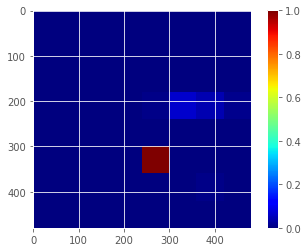

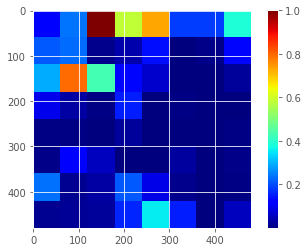

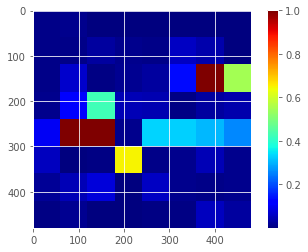


  1%|          | 4/614 [00:01<05:05,  1.99it/s]

dog_2009_000600.jpg
[[0.754      0.55750751]
 [0.6484     0.47462462]
 [0.6218     0.44459459]]
sofa 0.120342575
diningtable 0.10093188
horse 0.10052986
bicycle 0.0996196
cow 0.09746188
boat 0.09725304
cat 0.09698449
aeroplane 0.096909456
dog 0.096286915
motorbike 0.09368031
(480, 480, 3)
0.0312500011216589
sofa 0.14336015
cow 0.1401488
horse 0.12767723
dog 0.12299995
cat 0.099688195
diningtable 0.09413964
boat 0.088545546
aeroplane 0.080323
motorbike 0.058717605
bicycle 0.04439986
(480, 480, 3)
0.03094274047361978
dog 0.95928985
cow 0.023589429
cat 0.0069788652
horse 0.004702964
sofa 0.0035977536
motorbike 0.0007327541
diningtable 0.00043089702
boat 0.0003161666
bicycle 0.0003076001
aeroplane 5.367924e-05
(480, 480, 3)
0.031206257792504744


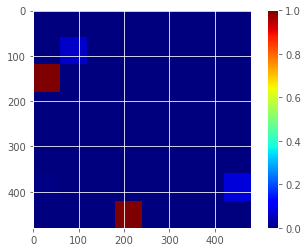

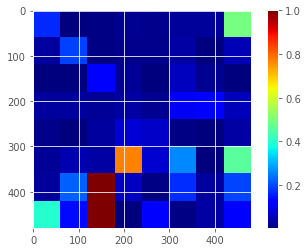

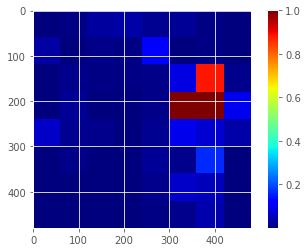


  1%|          | 5/614 [00:02<05:22,  1.89it/s]

dog_2008_005679.jpg
[[0.6167   0.266875]
 [0.5904   0.449875]
 [0.6555   0.459125]]
sofa 0.1205862
diningtable 0.102025844
horse 0.10158715
bicycle 0.09885324
boat 0.0981868
aeroplane 0.09755113
cow 0.09703899
cat 0.09655442
dog 0.0958539
motorbike 0.091762334
(480, 480, 3)
0.03125000145911848
dog 0.14206947
boat 0.13614355
horse 0.12199026
cow 0.114716806
sofa 0.10292641
aeroplane 0.101853184
diningtable 0.0754365
cat 0.07435326
motorbike 0.07156642
bicycle 0.058944106
(480, 480, 3)
0.031024523135783966
dog 0.95054173
cow 0.025636146
cat 0.010782142
sofa 0.0061739623
horse 0.0048973556
diningtable 0.0011119838
motorbike 0.00033040633
boat 0.00024356664
bicycle 0.00018539984
aeroplane 9.7217955e-05
(480, 480, 3)
0.031130056852127552


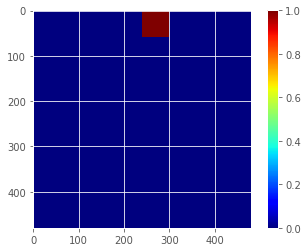

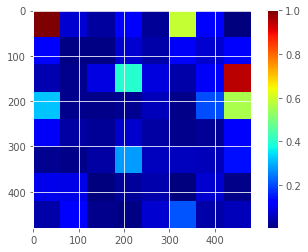

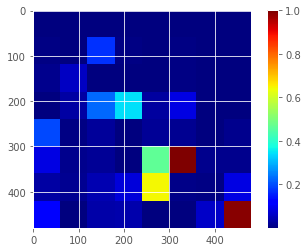


  1%|          | 6/614 [00:03<05:15,  1.93it/s]

dog_2008_002096.jpg
[[0.2107     0.3764    ]
 [0.5559     0.4744    ]
 [0.1529     0.7576    ]
 [0.1791     0.76973333]]
boat 0.14396138
cat 0.11457321
bicycle 0.10735572
aeroplane 0.10246138
diningtable 0.097854085
motorbike 0.09767087
horse 0.08793631
dog 0.08663986
sofa 0.083599254
cow 0.07794795
(480, 480, 3)
0.031249605479085365
aeroplane 0.13994007
boat 0.13908823
dog 0.12959248
horse 0.11833865
cow 0.10388816
sofa 0.102579206
cat 0.071677305
motorbike 0.06540991
bicycle 0.06492767
diningtable 0.06455835
(480, 480, 3)
0.031228579658318267
dog 0.90213776
cow 0.05851984
horse 0.014080901
cat 0.013591204
sofa 0.008157779
diningtable 0.0013220333
motorbike 0.0011480693
boat 0.00057633
bicycle 0.00034348445
aeroplane 0.00012270217
(480, 480, 3)
0.031128786994841562


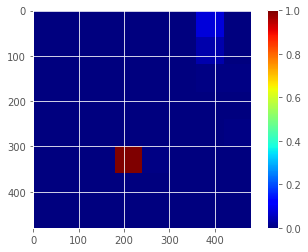

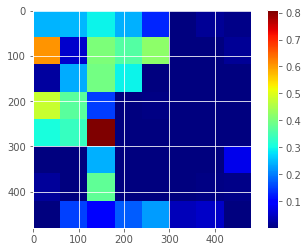

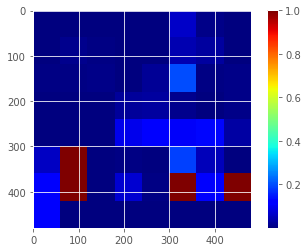


  1%|          | 7/614 [00:03<05:11,  1.95it/s]

dog_2008_002395.jpg
[[0.375      0.26300505]
 [0.4877     0.43068182]
 [0.5311     0.49419192]]
horse 0.12926334
diningtable 0.12757324
sofa 0.11163222
dog 0.106962904
bicycle 0.10062042
boat 0.09801325
cow 0.095708765
cat 0.09093667
motorbike 0.07371853
aeroplane 0.06557068
(480, 480, 3)
0.031244814752766387
dog 0.13199022
boat 0.12999626
horse 0.12787414
cow 0.116698615
sofa 0.11143983
aeroplane 0.091363505
diningtable 0.08280487
cat 0.077640325
bicycle 0.06560886
motorbike 0.064583376
(480, 480, 3)
0.03123013673530295
dog 0.8524517
cat 0.04758178
cow 0.046508692
horse 0.039606933
sofa 0.007060306
diningtable 0.0027796475
boat 0.0018413743
bicycle 0.0010064773
motorbike 0.0009729997
aeroplane 0.00019016024
(480, 480, 3)
0.028078917750463006


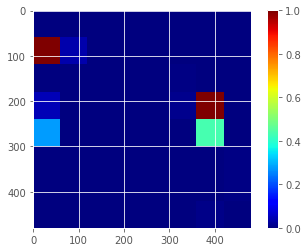

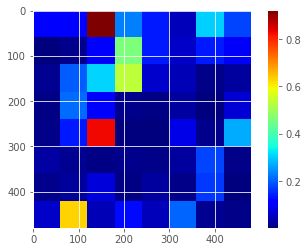

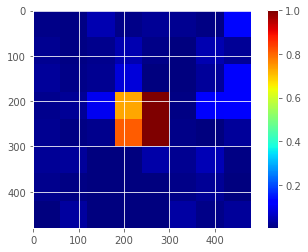


  1%|▏         | 8/614 [00:04<05:06,  1.98it/s]

dog_2010_004749.jpg
[[0.3731     0.4896    ]
 [0.2757     0.36786667]
 [0.4158     0.34813333]]
horse 0.15510891
cat 0.12725489
cow 0.11668095
boat 0.108318225
dog 0.106555425
motorbike 0.09223324
sofa 0.080748715
bicycle 0.07843781
diningtable 0.072998345
aeroplane 0.061663546
(480, 480, 3)
0.031249999146811182
cat 0.20583294
horse 0.118899755
sofa 0.10894051
diningtable 0.10525482
motorbike 0.0881658
cow 0.08791607
dog 0.08757799
boat 0.07502746
bicycle 0.06388702
aeroplane 0.058497615
(480, 480, 3)
0.03124993501018558
cat 0.92759717
dog 0.03051469
horse 0.020125745
cow 0.009611371
boat 0.005052785
motorbike 0.0029389472
diningtable 0.0025329592
sofa 0.00098634
bicycle 0.00038352484
aeroplane 0.00025646336
(480, 480, 3)
0.031054174564815185


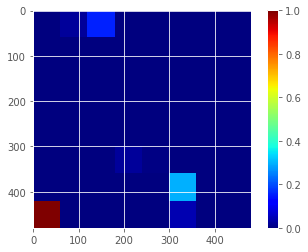

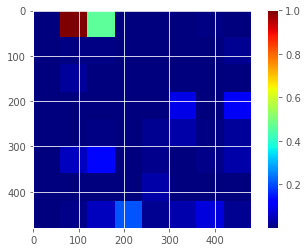

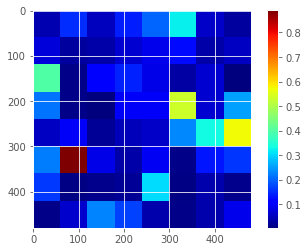


  1%|▏         | 9/614 [00:04<05:05,  1.98it/s]

dog_2008_008714.jpg
[[0.5324     0.57      ]
 [0.4318     0.62893333]
 [0.3279     0.59053333]]
boat 0.11853142
bicycle 0.11618356
aeroplane 0.11133139
sofa 0.10951202
horse 0.10618795
diningtable 0.10593434
dog 0.08859404
cow 0.083654776
cat 0.08147194
motorbike 0.078598544
(480, 480, 3)
0.031249998640588698
aeroplane 0.15400624
boat 0.13263533
dog 0.12724614
horse 0.11786918
cow 0.104652435
sofa 0.10060479
cat 0.0714844
bicycle 0.06688955
motorbike 0.064406365
diningtable 0.060205568
(480, 480, 3)
0.031227936697519
cow 0.41059166
horse 0.3679675
dog 0.1359723
sofa 0.04084787
motorbike 0.011241278
diningtable 0.010823304
cat 0.009077297
boat 0.00804644
bicycle 0.0033202923
aeroplane 0.0021119954
(480, 480, 3)
0.031224352308747427


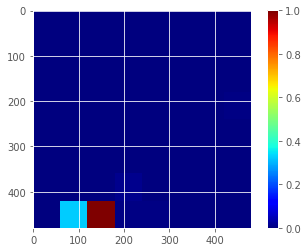

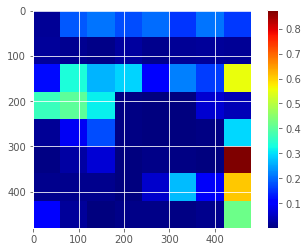

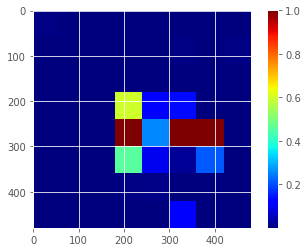


  2%|▏         | 10/614 [00:05<05:03,  1.99it/s]

aeroplane_2011_001081.jpg
[[0.5877     0.26951952]
 [0.5662     0.4960961 ]
 [0.4897     0.56501502]
 [0.4439     0.58303303]]
boat 0.3520253
aeroplane 0.14910161
bicycle 0.13925092
horse 0.07631993
diningtable 0.066704445
dog 0.059189517
motorbike 0.05608758
cat 0.038092826
sofa 0.03531791
cow 0.02791
(480, 480, 3)
0.031249994029604558
aeroplane 0.16970202
boat 0.1365707
horse 0.117433935
dog 0.11635996
sofa 0.100386925
cow 0.0999808
cat 0.070824385
bicycle 0.06815545
motorbike 0.062431596
diningtable 0.05815413
(480, 480, 3)
0.031249609406700407
aeroplane 0.98127156
boat 0.01502052
motorbike 0.0022692448
bicycle 0.0011547487
dog 0.00010982363
sofa 8.094582e-05
diningtable 4.8557285e-05
horse 3.236013e-05
cow 7.4537475e-06
cat 4.796707e-06
(480, 480, 3)
0.031161232023260155


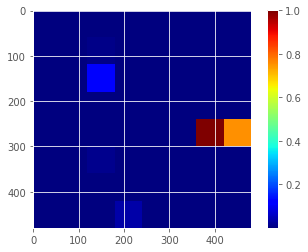

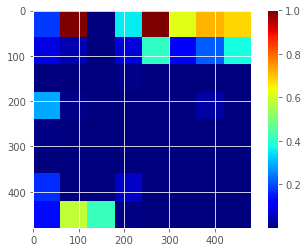

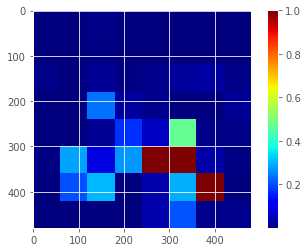


 21%|██        | 127/614 [00:05<02:52,  2.83it/s]

aeroplane_2009_003107.jpg
[[0.4181     0.72837838]
 [0.5479     0.56681682]
 [0.3238     0.63258258]]
sofa 0.120499164
diningtable 0.106934555
horse 0.10144635
boat 0.09992229
cow 0.09938481
dog 0.09898032
bicycle 0.097507164
cat 0.09724345
motorbike 0.09160983
aeroplane 0.08647203
(480, 480, 3)
0.031249997905303556
boat 0.13566777
dog 0.1329973
aeroplane 0.12832476
horse 0.11733966
sofa 0.106953494
cow 0.10673878
cat 0.070995875
diningtable 0.070136376
motorbike 0.06661131
bicycle 0.06423463
(480, 480, 3)
0.030492574731169952
aeroplane 0.95659846
boat 0.03687092
motorbike 0.0037142439
bicycle 0.0019930312
sofa 0.00028265925
dog 0.00019700173
horse 0.00016190276
diningtable 0.00011250477
cow 5.7290763e-05
cat 1.18584585e-05
(480, 480, 3)
0.031204493217472873


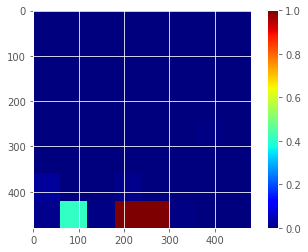

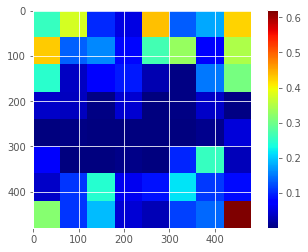

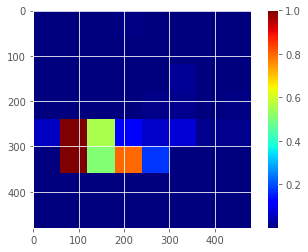

aeroplane_2011_002380.jpg
[[0.5079     0.78378378]
 [0.4193     0.61711712]]
aeroplane 0.51055413
boat 0.24554518
bicycle 0.08634322
motorbike 0.039196882
dog 0.036717992
diningtable 0.025258077
horse 0.021263389
sofa 0.017403167
cat 0.00894027
cow 0.008777682
(480, 480, 3)
0.031249797621669413
aeroplane 0.20323215
boat 0.16676794
dog 0.1017344
horse 0.09501002
sofa 0.09153703
cow 0.07804371
bicycle 0.07618625
motorbike 0.07033911
diningtable 0.060509022
cat 0.056640394
(480, 480, 3)
0.031247846675205092
aeroplane 0.9743192
boat 0.02117556
motorbike 0.0024416004
bicycle 0.0016452585
dog 0.00015002386
sofa 9.639134e-05
diningtable 8.872562e-05
horse 5.685869e-05
cow 1.5829162e-05
cat 1.0510891e-05
(480, 480, 3)
0.02834651361973428


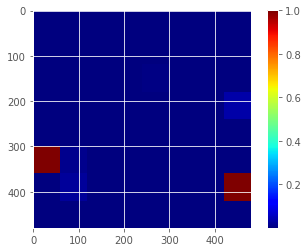

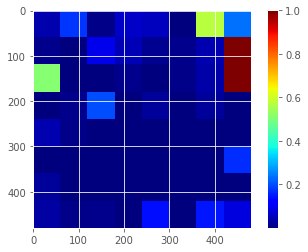

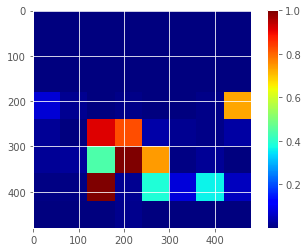

aeroplane_2011_001962.jpg
[[0.433      0.56306306]
 [0.568      0.66681682]
 [0.6217     0.68483483]]
boat 0.16316032
aeroplane 0.16223986
bicycle 0.12646219
sofa 0.11340818
horse 0.097390756
diningtable 0.09560565
dog 0.06972207
motorbike 0.06623564
cow 0.055014066
cat 0.050761238
(480, 480, 3)
0.031249419038724992
aeroplane 0.14606461
boat 0.1313717
dog 0.12286977
horse 0.11602451
cow 0.105176896
sofa 0.10376384
cat 0.07420742
bicycle 0.06845204
motorbike 0.06645159
diningtable 0.06561761
(480, 480, 3)
0.03124719992037228
aeroplane 0.93813497
boat 0.045088813
motorbike 0.007334693
bicycle 0.005315444
horse 0.0016120482
dog 0.0011533909
diningtable 0.0005088223
sofa 0.00038883314
cow 0.0003601627
cat 0.00010289001
(480, 480, 3)
0.03109805657555853


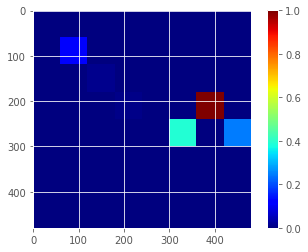

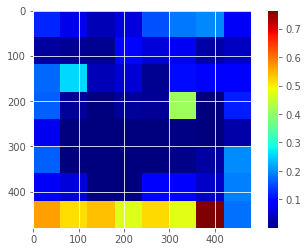

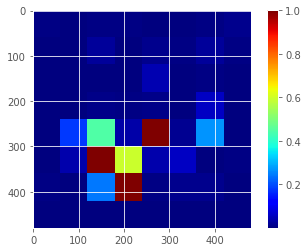

aeroplane_2008_002551.jpg
[[0.3205 0.8324]
 [0.79   0.5896]]
sofa 0.12064391
diningtable 0.102100775
horse 0.101962924
bicycle 0.09918789
boat 0.098700784
aeroplane 0.098350056
cow 0.096531406
cat 0.09603451
dog 0.095376916
motorbike 0.091110826
(480, 480, 3)
0.03124999684788511
boat 0.15081848
dog 0.12953384
horse 0.122450195
aeroplane 0.11840798
sofa 0.10472004
cow 0.10282213
diningtable 0.072226495
cat 0.071839936
bicycle 0.064290315
motorbike 0.06289058
(480, 480, 3)
0.03124793402889736
aeroplane 0.5417575
boat 0.43616527
bicycle 0.0106480075
diningtable 0.0032263305
motorbike 0.0030354492
dog 0.0019409576
horse 0.0015191234
sofa 0.0014374721
cow 0.00016126575
cat 0.000108596716
(480, 480, 3)
0.03101666406928416


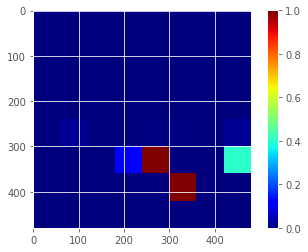

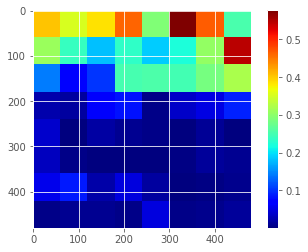

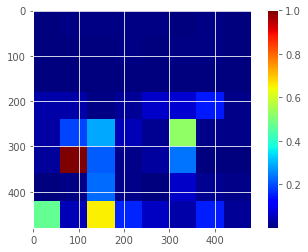

aeroplane_2008_004348.jpg
[[0.4397 0.6648]
 [0.4665 0.4728]]
boat 0.22261733
aeroplane 0.1514603
motorbike 0.103978
dog 0.094500914
horse 0.09223488
diningtable 0.08924822
sofa 0.07722671
cow 0.07462976
cat 0.05087364
bicycle 0.043230258
(480, 480, 3)
0.0312500003864078
boat 0.14274915
dog 0.13600685
horse 0.12210808
aeroplane 0.111381836
cow 0.10914598
sofa 0.1067983
cat 0.073578455
diningtable 0.07075535
motorbike 0.06622392
bicycle 0.061252087
(480, 480, 3)
0.03124996818840355
motorbike 0.7170552
bicycle 0.06565807
aeroplane 0.04640037
dog 0.038259257
cow 0.03195863
boat 0.030975536
diningtable 0.024260359
sofa 0.02287541
horse 0.019217458
cat 0.0033397735
(480, 480, 3)
0.031247987245421882


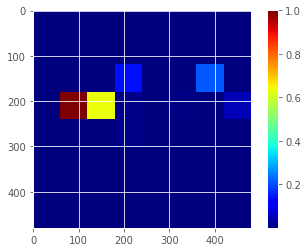

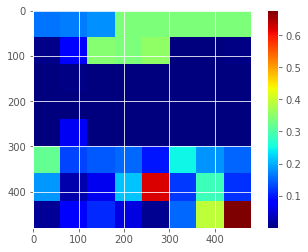

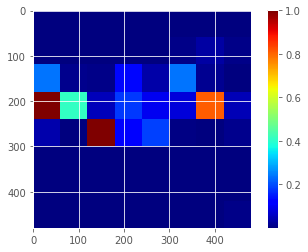

aeroplane_2008_005078.jpg
[[0.423      0.63263473]
 [0.4857     0.47020958]]
boat 0.34250674
aeroplane 0.19905087
bicycle 0.15193842
dog 0.06353027
horse 0.060342483
diningtable 0.052474663
motorbike 0.04645843
cow 0.029884566
sofa 0.029117284
cat 0.024696216
(480, 480, 3)
0.03124989129914998
aeroplane 0.1563169
boat 0.13445936
dog 0.123944856
horse 0.118375026
cow 0.10407536
sofa 0.10187693
cat 0.07115285
bicycle 0.065327644
motorbike 0.06330233
diningtable 0.0611687
(480, 480, 3)
0.031191464377299916
aeroplane 0.9689386
boat 0.02449622
motorbike 0.003612719
bicycle 0.0025897268
dog 0.00013130157
diningtable 8.361913e-05
sofa 7.358189e-05
horse 5.7785885e-05
cat 8.316506e-06
cow 8.196211e-06
(480, 480, 3)
0.031141073683315312


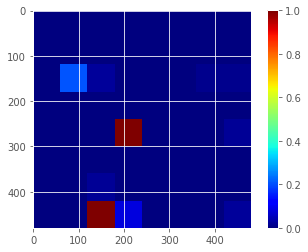

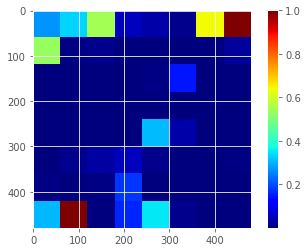

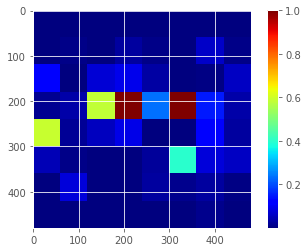

aeroplane_2008_000805.jpg
[[0.5035     0.53973333]
 [0.8026     0.47466667]]
boat 0.21216138
aeroplane 0.17685533
bicycle 0.14858304
horse 0.11673366
diningtable 0.08703954
sofa 0.08109954
motorbike 0.05140988
dog 0.050047595
cow 0.042297784
cat 0.03377226
(480, 480, 3)
0.03124999889897477
boat 0.14954822
dog 0.13090125
aeroplane 0.12145263
horse 0.120237835
cow 0.10423236
sofa 0.09738188
cat 0.07262248
motorbike 0.07190434
diningtable 0.0659778
bicycle 0.065741204
(480, 480, 3)
0.03121723567483706
aeroplane 0.9717872
boat 0.022587365
motorbike 0.0032379217
bicycle 0.0019587672
dog 0.00014809959
sofa 0.00011689593
diningtable 8.904464e-05
horse 5.591035e-05
cow 1.0680686e-05
cat 8.130832e-06
(480, 480, 3)
0.03116069424928014


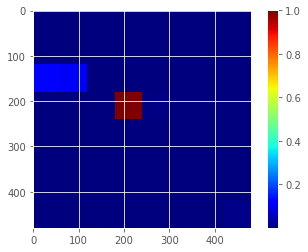

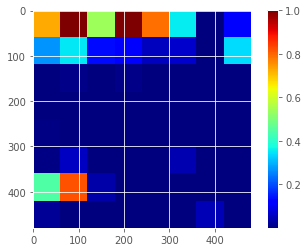

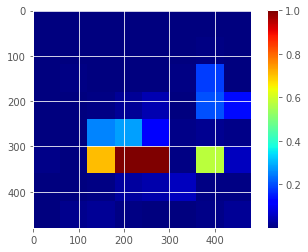


 22%|██▏       | 134/614 [00:09<03:12,  2.50it/s]

aeroplane_2009_002272.jpg
[[0.4328     0.49685629]
 [0.6568     0.58652695]]
boat 0.19001946
bicycle 0.13898192
aeroplane 0.12402811
horse 0.11577335
motorbike 0.089192025
dog 0.08913825
diningtable 0.073419295
cow 0.062200014
sofa 0.06084904
cat 0.05639859
(480, 480, 3)
0.03124825586437193
boat 0.14083746
dog 0.12675169
horse 0.120249696
aeroplane 0.11047093
sofa 0.107893
cow 0.10502498
cat 0.076777205
diningtable 0.07635102
bicycle 0.06804852
motorbike 0.0675955
(480, 480, 3)
0.030395905067133633
aeroplane 0.92603534
boat 0.061745726
bicycle 0.005828999
motorbike 0.004881525
dog 0.00044621385
diningtable 0.00037321888
horse 0.00029603497
sofa 0.00023186291
cow 9.392261e-05
cat 6.7200584e-05
(480, 480, 3)
0.030754973678995157


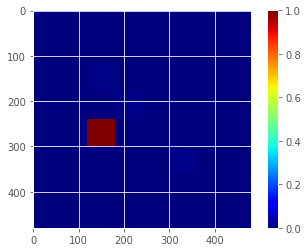

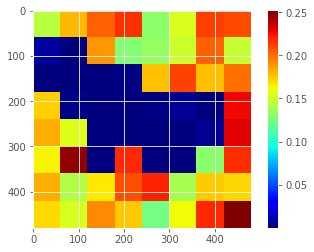

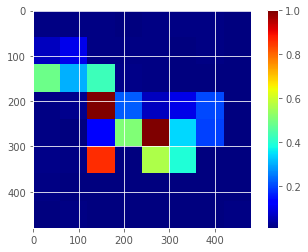

aeroplane_2008_004532.jpg
[[0.4704     0.57852853]
 [0.6419     0.57762763]]
diningtable 0.14188746
sofa 0.1290989
bicycle 0.12810443
boat 0.119848125
horse 0.09532416
motorbike 0.08420965
aeroplane 0.08253575
dog 0.08244499
cat 0.07525016
cow 0.061296374
(480, 480, 3)
0.03124922809222938
aeroplane 0.13797365
boat 0.13740003
dog 0.13037065
horse 0.12063871
cow 0.10546595
sofa 0.10406014
cat 0.07200176
diningtable 0.06516449
motorbike 0.06367727
bicycle 0.063247345
(480, 480, 3)
0.031249953665627217
aeroplane 0.9799177
boat 0.016426988
motorbike 0.0022365346
bicycle 0.0011703927
dog 9.562215e-05
sofa 6.771224e-05
diningtable 4.3376014e-05
horse 3.1452586e-05
cow 5.6142826e-06
cat 4.4886465e-06
(480, 480, 3)
0.03120456026172924


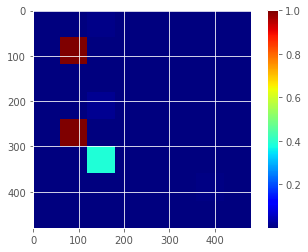

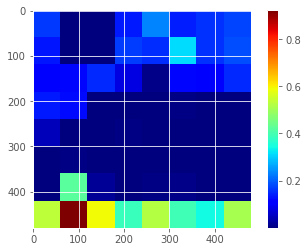

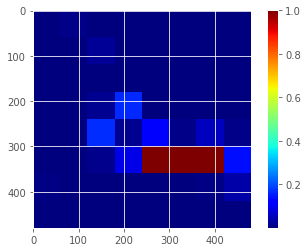


 23%|██▎       | 139/614 [00:10<02:41,  2.94it/s]

boat_2011_001176.jpg
[[0.6692     0.63346667]
 [0.5187     0.4788    ]]
boat 0.5636505
aeroplane 0.082636006
bicycle 0.08155156
horse 0.07688295
diningtable 0.049916774
sofa 0.038691036
dog 0.03375925
motorbike 0.028653277
cat 0.022459522
cow 0.021799138
(480, 480, 3)
0.031249988376711977
aeroplane 0.16320811
boat 0.13759199
dog 0.13142188
horse 0.11550644
sofa 0.11212426
cow 0.1060972
cat 0.06515281
bicycle 0.059960477
motorbike 0.05532341
diningtable 0.05361342
(480, 480, 3)
0.031249998636430895
boat 0.97800696
aeroplane 0.010726666
diningtable 0.0033457722
bicycle 0.0030876903
horse 0.0020804657
motorbike 0.0014655621
dog 0.0007611322
cow 0.00021787523
sofa 0.00020038922
cat 0.000107541564
(480, 480, 3)
0.028787640710139062


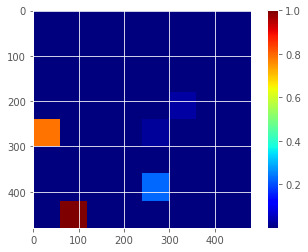

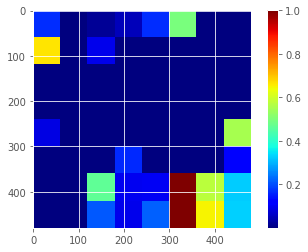

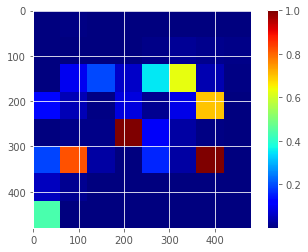


 32%|███▏      | 194/614 [00:10<01:41,  4.16it/s]

boat_2009_002727.jpg
[[0.404      0.40565749]
 [0.836      0.65764526]]
sofa 0.13502426
bicycle 0.11463276
diningtable 0.108125284
dog 0.10164833
motorbike 0.099486135
aeroplane 0.09832337
horse 0.09381353
cow 0.08823933
boat 0.085943334
cat 0.07476366
(480, 480, 3)
0.031248273606035954
boat 0.17098692
dog 0.117349885
aeroplane 0.116111495
sofa 0.1028296
horse 0.09631774
diningtable 0.09429761
cow 0.08456044
motorbike 0.08205789
bicycle 0.07513872
cat 0.060349707
(480, 480, 3)
0.03096897893010464
boat 0.9537802
diningtable 0.0132039795
aeroplane 0.012594586
bicycle 0.010891233
horse 0.005325809
motorbike 0.002282023
dog 0.0009806242
sofa 0.00045797948
cow 0.00036788353
cat 0.00011559243
(480, 480, 3)
0.0299000679758592


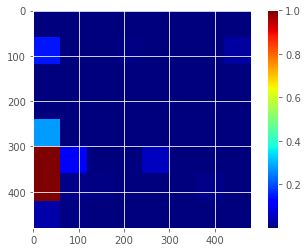

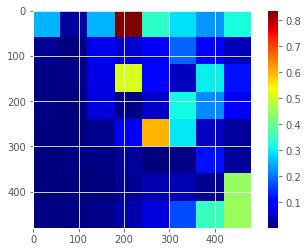

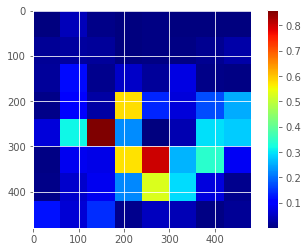

boat_2010_002393.jpg
[[0.6754     0.74250646]
 [0.4092     0.7375969 ]]
boat 0.34297022
aeroplane 0.13927503
bicycle 0.12131806
horse 0.11865873
dog 0.07897422
diningtable 0.058573842
cow 0.040785793
motorbike 0.037349667
sofa 0.03279654
cat 0.029297842
(480, 480, 3)
0.031241534721238088
boat 0.15569313
dog 0.12861341
aeroplane 0.122579664
horse 0.12106118
cow 0.100848146
sofa 0.09753291
cat 0.07118874
diningtable 0.068429634
motorbike 0.067970395
bicycle 0.06608281
(480, 480, 3)
0.031094537795623326
boat 0.97302824
aeroplane 0.011589351
bicycle 0.005720067
diningtable 0.004138131
horse 0.0023152763
motorbike 0.0021796897
dog 0.00056307676
cow 0.00022128102
sofa 0.00016276889
cat 8.2129955e-05
(480, 480, 3)
0.031222888413310557


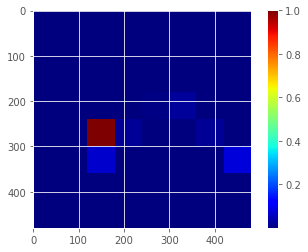

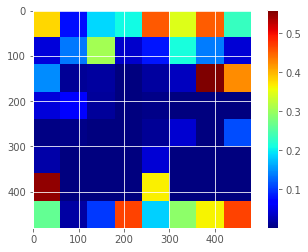

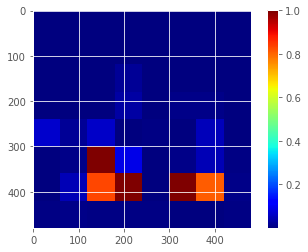

boat_2010_001126.jpg
[[0.6016     0.5358209 ]
 [0.4034     0.56656716]]
boat 0.15805887
horse 0.11747502
cat 0.10414635
aeroplane 0.101954706
cow 0.10126046
dog 0.09967599
sofa 0.0921781
diningtable 0.089822985
bicycle 0.08405807
motorbike 0.051369447
(480, 480, 3)
0.031249998917417556
boat 0.25503108
aeroplane 0.15297012
bicycle 0.14494888
horse 0.12967612
diningtable 0.07865327
dog 0.06569519
sofa 0.053504523
cow 0.045371383
motorbike 0.038153023
cat 0.03599648
(480, 480, 3)
0.031239813408695305
boat 0.9446453
aeroplane 0.015076757
horse 0.010508713
diningtable 0.010155951
bicycle 0.009871151
motorbike 0.003632928
dog 0.003174269
cow 0.0011572627
cat 0.0010239461
sofa 0.0007538547
(480, 480, 3)
0.030448343498505892


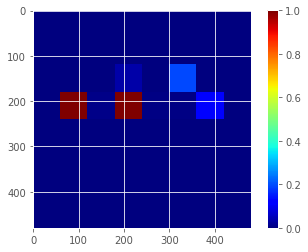

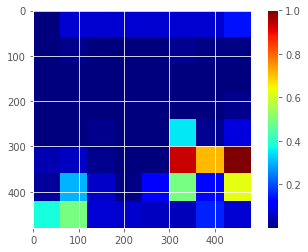

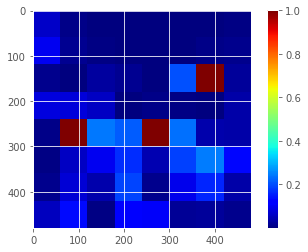

boat_2011_002872.jpg
[[0.3882     0.6928    ]
 [0.4112     0.42773333]
 [0.759      0.3296    ]]
boat 0.38885948
horse 0.114276305
aeroplane 0.1093065
bicycle 0.09680811
dog 0.07119302
diningtable 0.054653727
motorbike 0.050578307
sofa 0.042410403
cat 0.0368088
cow 0.035105344
(480, 480, 3)
0.03124590862861283
boat 0.9211507
aeroplane 0.027264513
bicycle 0.01768793
diningtable 0.010957525
horse 0.010100616
dog 0.004813049
motorbike 0.004412835
cow 0.0013663982
sofa 0.0012680329
cat 0.0009783249
(480, 480, 3)
0.031200676105527236
boat 0.48821315
aeroplane 0.11113572
horse 0.1057749
bicycle 0.08419767
diningtable 0.06280296
dog 0.052724477
motorbike 0.035769127
cow 0.025349619
sofa 0.018123573
cat 0.015908862
(480, 480, 3)
0.012951057977865332


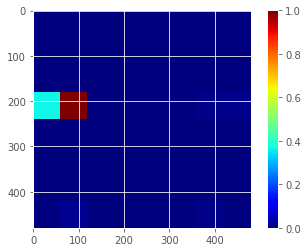

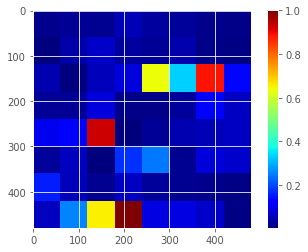

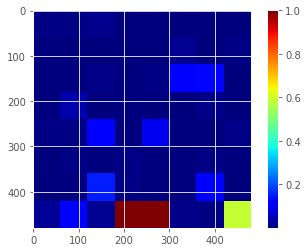

boat_2010_004138.jpg
[[0.5427     0.60271186]
 [0.4747     0.47745763]]
boat 0.34429947
bicycle 0.13347523
horse 0.12513244
diningtable 0.09181931
aeroplane 0.09077164
motorbike 0.04873169
dog 0.047823053
sofa 0.046924688
cat 0.036692128
cow 0.034330305
(480, 480, 3)
0.031249887217031924
boat 0.14812645
dog 0.13230704
horse 0.12302253
aeroplane 0.12191668
cow 0.1049847
sofa 0.102567896
cat 0.0724057
diningtable 0.06696207
motorbike 0.06494789
bicycle 0.062759094
(480, 480, 3)
0.030970501654202565
boat 0.7009182
aeroplane 0.09068985
bicycle 0.07750686
horse 0.038804688
motorbike 0.030577293
diningtable 0.02176579
dog 0.018573342
cow 0.008999942
cat 0.0075628813
sofa 0.004601176
(480, 480, 3)
0.031154674567005713


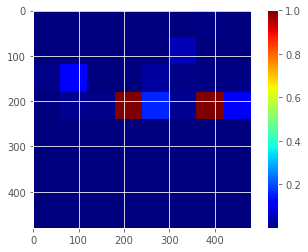

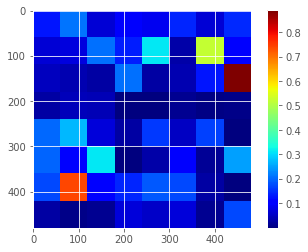

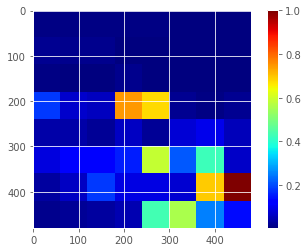

boat_2009_000608.jpg
[[0.2883     0.73066667]
 [0.4811     0.7676    ]]
boat 0.38738164
aeroplane 0.18057431
bicycle 0.14646775
horse 0.059204746
diningtable 0.057783272
motorbike 0.052415155
dog 0.05234943
cow 0.024921415
sofa 0.021847762
cat 0.017054483
(480, 480, 3)
0.03124928517676408
boat 0.29097736
aeroplane 0.2624376
bicycle 0.09784172
horse 0.0861077
dog 0.06161306
sofa 0.058116592
diningtable 0.046369664
cow 0.039161608
cat 0.029749794
motorbike 0.027624898
(480, 480, 3)
0.03124921108970291
boat 0.95150703
aeroplane 0.022442572
bicycle 0.012019439
motorbike 0.0053032245
diningtable 0.0038217024
horse 0.003509181
dog 0.0006811965
cow 0.00039774014
sofa 0.00018417372
cat 0.00013368891
(480, 480, 3)
0.028434231332887805


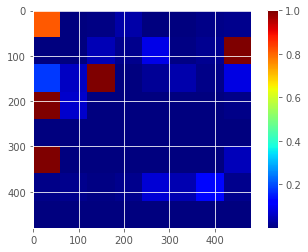

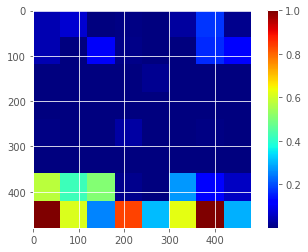

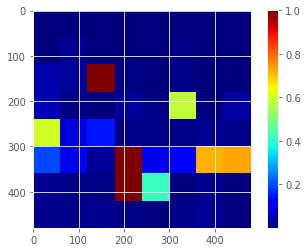


 33%|███▎      | 200/614 [00:13<02:13,  3.09it/s]

boat_2008_003886.jpg
[[0.1726     0.17360743]
 [0.3908     0.35570292]
 [0.6739     0.44522546]]
boat 0.26873422
bicycle 0.14156342
aeroplane 0.13722642
motorbike 0.13044561
dog 0.076344274
horse 0.06977253
diningtable 0.05750261
cow 0.044463396
cat 0.042506002
sofa 0.031441484
(480, 480, 3)
0.028742442875500086
boat 0.2393413
aeroplane 0.16471234
horse 0.115884416
dog 0.09184151
sofa 0.090212844
bicycle 0.081838064
cow 0.064300686
diningtable 0.06321956
cat 0.050620314
motorbike 0.038029008
(480, 480, 3)
0.03124927594978999
boat 0.94288963
aeroplane 0.039028045
diningtable 0.005808722
bicycle 0.004786927
motorbike 0.0029563871
horse 0.0024495055
dog 0.0013841152
cat 0.00026780364
sofa 0.00025074516
cow 0.0001780841
(480, 480, 3)
0.03099357464577679


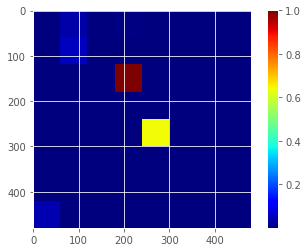

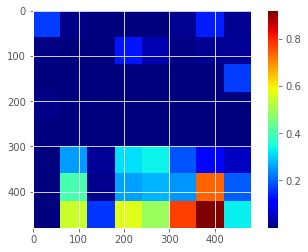

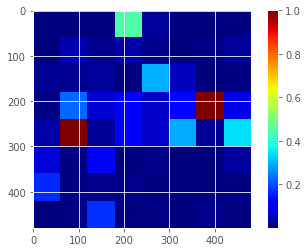

boat_2011_003115.jpg
[[0.4907     0.63386667]
 [0.6388     0.588     ]]
boat 0.40294158
aeroplane 0.14697035
bicycle 0.13805467
diningtable 0.087361656
horse 0.06606593
motorbike 0.046717186
dog 0.043970447
sofa 0.034180008
cow 0.020753972
cat 0.012984247
(480, 480, 3)
0.031248283073511796
boat 0.96140736
aeroplane 0.015950853
bicycle 0.0074904147
diningtable 0.0070305364
horse 0.0030871884
motorbike 0.0027190996
dog 0.0013914184
cow 0.00037521592
sofa 0.0002969895
cat 0.0002510657
(480, 480, 3)
0.030751479705457996
boat 0.9722252
aeroplane 0.01732834
diningtable 0.0036210895
bicycle 0.0031197036
motorbike 0.001602679
horse 0.001143665
dog 0.00050689414
sofa 0.0003068629
cow 8.165077e-05
cat 6.389393e-05
(480, 480, 3)
0.0312492494694714


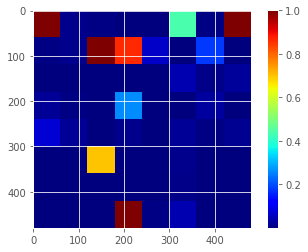

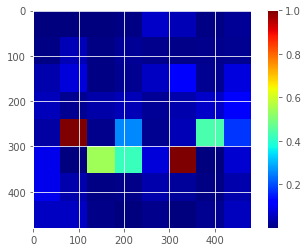

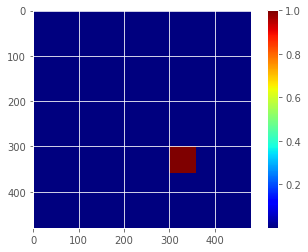

boat_2008_002281.jpg
[[0.6881     0.04266667]
 [0.5245     0.49906667]
 [0.4988     0.58186667]]
boat 0.32844415
bicycle 0.18407208
aeroplane 0.16011152
motorbike 0.10122849
diningtable 0.08105852
horse 0.049373683
sofa 0.036102146
dog 0.034236677
cat 0.014085006
cow 0.011287792
(480, 480, 3)
0.030916140962700567
boat 0.19862378
aeroplane 0.19799699
horse 0.11472605
dog 0.091947
sofa 0.08793705
bicycle 0.08699117
cow 0.07011989
diningtable 0.05978025
cat 0.05036559
motorbike 0.041512188
(480, 480, 3)
0.0312499892935183
boat 0.9474176
aeroplane 0.0288959
horse 0.008790034
bicycle 0.0044447
diningtable 0.0034609037
dog 0.00224562
motorbike 0.0021234185
cow 0.0012575967
sofa 0.0008534413
cat 0.0005107409
(480, 480, 3)
0.03012398835971908


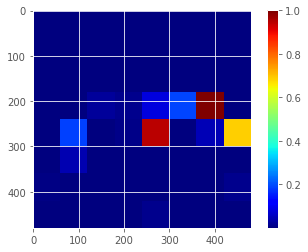

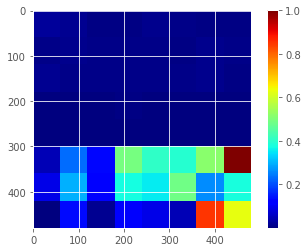

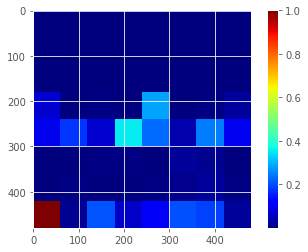


 33%|███▎      | 204/614 [00:15<02:21,  2.91it/s]

bicycle_2009_004822.jpg
[[0.4589     0.38013333]
 [0.5506     0.54053333]]
sofa 0.12101108
bicycle 0.10290498
horse 0.10094147
cow 0.10045005
diningtable 0.09984753
aeroplane 0.09816868
dog 0.09601346
boat 0.09547151
motorbike 0.09470354
cat 0.09048771
(480, 480, 3)
0.03125000067683858
dog 0.13999291
boat 0.13360675
horse 0.12112585
cow 0.11184205
aeroplane 0.110573806
sofa 0.10813619
cat 0.07289988
diningtable 0.07068478
motorbike 0.0673908
bicycle 0.063746996
(480, 480, 3)
0.031247779900979822
bicycle 0.91558737
motorbike 0.03863983
horse 0.015592417
diningtable 0.012094763
dog 0.0069155074
boat 0.004981165
sofa 0.003766236
aeroplane 0.0012967763
cow 0.00075694174
cat 0.0003690211
(480, 480, 3)
0.030703022322853712


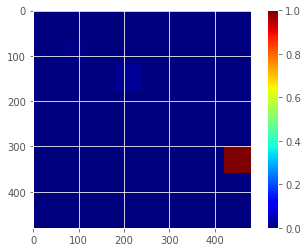

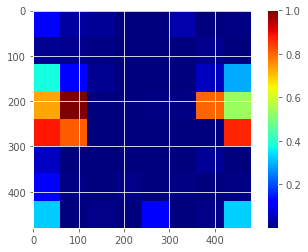

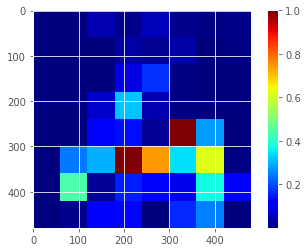


 40%|███▉      | 244/614 [00:15<01:30,  4.09it/s]

bicycle_2008_005553.jpg
[[0.6632   0.4635  ]
 [0.6166   0.3042  ]
 [0.5233   0.255375]]
sofa 0.17868796
diningtable 0.15079309
cat 0.1209113
bicycle 0.10161984
horse 0.09008892
motorbike 0.0843419
dog 0.08207961
boat 0.0720752
cow 0.061194856
aeroplane 0.058207326
(480, 480, 3)
0.031249996221611
aeroplane 0.15027091
boat 0.13147137
dog 0.12209352
horse 0.1165793
cow 0.10432649
sofa 0.10211246
cat 0.07385357
bicycle 0.06871032
motorbike 0.06650357
diningtable 0.06407848
(480, 480, 3)
0.031249670437912158
motorbike 0.8992978
bicycle 0.08188554
aeroplane 0.007895773
diningtable 0.004088344
boat 0.0026011767
dog 0.0014184827
sofa 0.0013573235
horse 0.00089305313
cow 0.00048495064
cat 7.7655415e-05
(480, 480, 3)
0.030314023600979567


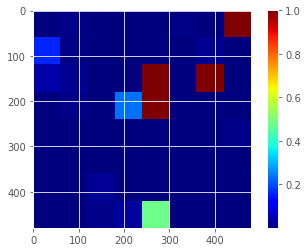

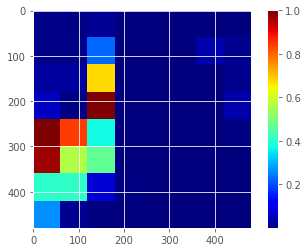

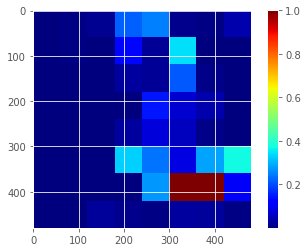

bicycle_2010_000557.jpg
[[0.5275     0.58753754]
 [0.3135     0.41231231]
 [0.453      0.47777778]]
boat 0.15505992
bicycle 0.1466468
aeroplane 0.11739164
horse 0.11512346
diningtable 0.1086286
sofa 0.08180152
dog 0.07752768
motorbike 0.07095756
cow 0.06701447
cat 0.05984837
(480, 480, 3)
0.03124999861860063
dog 0.13554569
boat 0.1222928
horse 0.11733187
cow 0.11451949
sofa 0.1126256
aeroplane 0.11066626
diningtable 0.07922354
motorbike 0.0697773
cat 0.06948758
bicycle 0.06852989
(480, 480, 3)
0.03124942119723606
bicycle 0.92183477
motorbike 0.026437286
diningtable 0.018931117
horse 0.018804006
boat 0.005062544
sofa 0.0050199195
dog 0.002335783
aeroplane 0.0008573638
cow 0.0005719319
cat 0.00014516884
(480, 480, 3)
0.031165315819890793


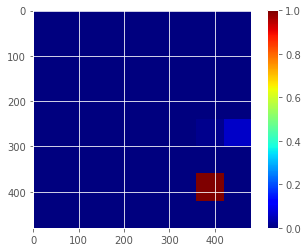

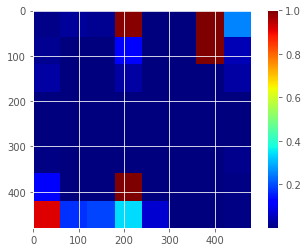

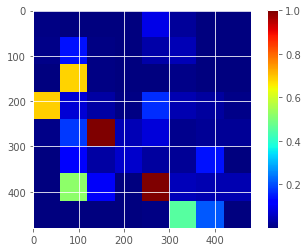

bicycle_2011_002281.jpg
[[0.7455 0.939 ]
 [0.4977 0.7358]
 [0.7404 0.6853]
 [0.802  0.6775]]
sofa 0.12742478
diningtable 0.105792046
bicycle 0.10232666
horse 0.100911655
dog 0.09812691
cow 0.09697243
boat 0.09626868
aeroplane 0.09272516
motorbike 0.08986182
cat 0.08958987
(480, 480, 3)
0.031249902064733805
aeroplane 0.14278212
boat 0.13546374
dog 0.12767215
horse 0.11388964
cow 0.10859536
sofa 0.1080168
cat 0.06863917
bicycle 0.065513864
diningtable 0.065271206
motorbike 0.064156055
(480, 480, 3)
0.030794681900147225
diningtable 0.5962088
motorbike 0.12298293
sofa 0.103315674
bicycle 0.07674039
horse 0.06364555
cow 0.017226562
boat 0.008829189
dog 0.0057883747
aeroplane 0.0040788082
cat 0.001183659
(480, 480, 3)
0.031168815207138323


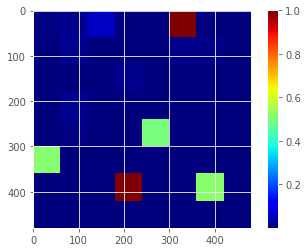

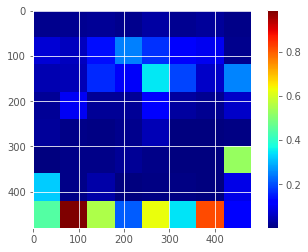

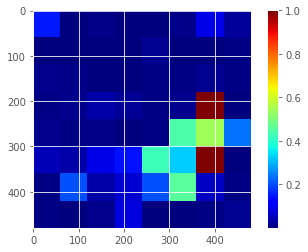

bicycle_2008_004482.jpg
[[0.3316     0.72226667]
 [0.3906     0.562     ]
 [0.232      0.5528    ]
 [0.185      0.56066667]]
bicycle 0.17000847
boat 0.16005827
aeroplane 0.12795553
horse 0.11892638
diningtable 0.112307094
sofa 0.09117326
dog 0.0634252
cow 0.05426863
motorbike 0.05407444
cat 0.04780264
(480, 480, 3)
0.0312500007947733
dog 0.14155225
boat 0.13752642
horse 0.12120154
cow 0.11013707
aeroplane 0.10995079
sofa 0.1070336
cat 0.07428114
diningtable 0.0683536
motorbike 0.06715526
bicycle 0.06280832
(480, 480, 3)
0.030273807213660575
motorbike 0.6874757
bicycle 0.26276594
dog 0.017935798
diningtable 0.008629622
boat 0.0063867704
horse 0.0049491376
sofa 0.0043032863
aeroplane 0.004205916
cow 0.0028405956
cat 0.0005071837
(480, 480, 3)
0.03116962320362404


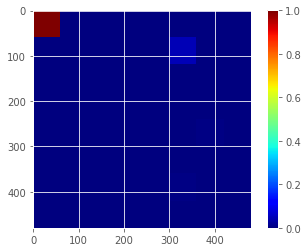

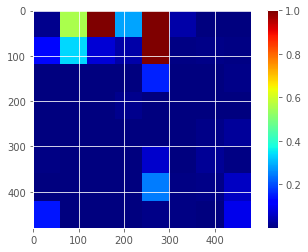

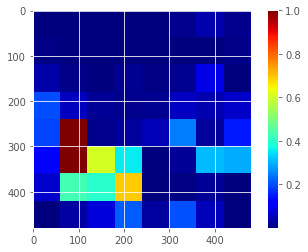

bicycle_2009_001642.jpg
[[0.4725     0.69329897]
 [0.7147     0.43582474]
 [0.6117     0.32061856]]
diningtable 0.17823753
boat 0.14415996
horse 0.11163497
sofa 0.09833142
dog 0.08507396
bicycle 0.08472992
cat 0.0817496
cow 0.07819711
aeroplane 0.07426971
motorbike 0.06361581
(480, 480, 3)
0.031249999683697783
boat 0.14147867
dog 0.12846686
horse 0.11915598
aeroplane 0.11147854
sofa 0.1094921
cow 0.10398074
cat 0.07585817
diningtable 0.0757059
motorbike 0.06858801
bicycle 0.06579502
(480, 480, 3)
0.03124941788155411
bicycle 0.92159295
motorbike 0.043759942
horse 0.011576055
diningtable 0.011529606
boat 0.0045586666
sofa 0.003250248
dog 0.0021325357
aeroplane 0.0008286583
cow 0.00063194707
cat 0.00013948946
(480, 480, 3)
0.03111338750102277


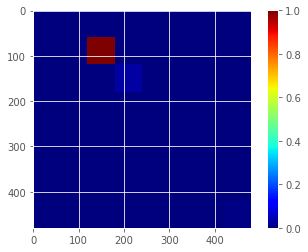

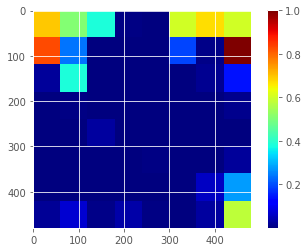

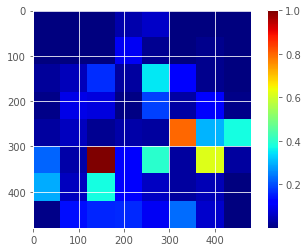


 41%|████      | 249/614 [00:18<01:56,  3.14it/s]

bicycle_2009_002400.jpg
[[0.33       0.04032738]
 [0.2405     0.009375  ]
 [0.3306     0.20639881]
 [0.3737     0.25401786]]
boat 0.2135471
bicycle 0.15961641
aeroplane 0.14275937
motorbike 0.13788712
dog 0.082194276
diningtable 0.066461585
horse 0.06433179
sofa 0.049441095
cat 0.044284314
cow 0.039477
(480, 480, 3)
0.001456811879857512
dog 0.14201573
boat 0.11928872
aeroplane 0.11571668
horse 0.110209994
cow 0.10404827
bicycle 0.09875461
motorbike 0.088624574
sofa 0.08267522
cat 0.07837179
diningtable 0.0602944
(480, 480, 3)
0.031102057618909384
bicycle 0.90462077
motorbike 0.06692274
diningtable 0.009775872
horse 0.007852383
boat 0.0048395833
sofa 0.0024133767
dog 0.0017983265
aeroplane 0.001095706
cow 0.00053067866
cat 0.00015049207
(480, 480, 3)
0.031228789882590036


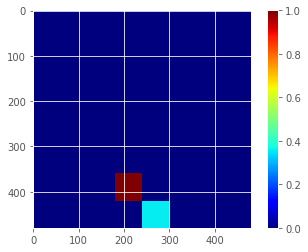

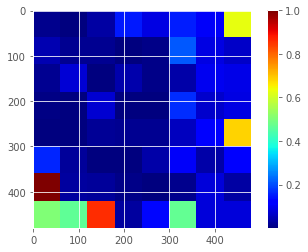

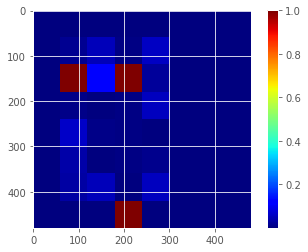

bicycle_2009_000573.jpg
[[0.608      0.75786667]
 [0.5616     0.59946667]
 [0.4563     0.54306667]]
sofa 0.11863913
bicycle 0.10405774
horse 0.09958202
diningtable 0.09862598
dog 0.09786607
motorbike 0.09674934
aeroplane 0.09666183
cat 0.09640136
cow 0.0959362
boat 0.0954804
(480, 480, 3)
0.031249992570858625
dog 0.16485168
bicycle 0.11785333
motorbike 0.113378316
aeroplane 0.09870199
sofa 0.09558691
horse 0.094083466
cow 0.09235698
boat 0.08793014
diningtable 0.07014451
cat 0.06511271
(480, 480, 3)
0.03122737628922323
bicycle 0.93006843
motorbike 0.03435752
horse 0.0153095545
diningtable 0.009062829
dog 0.003640044
sofa 0.003228009
boat 0.0030182044
aeroplane 0.0006545343
cow 0.0005327917
cat 0.0001280946
(480, 480, 3)
0.031238462434789227


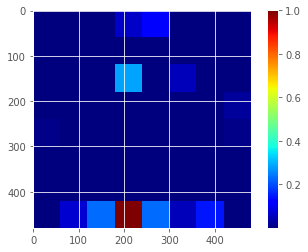

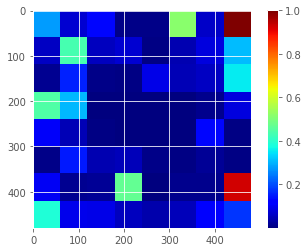

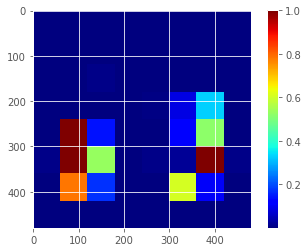

bicycle_2011_002388.jpg
[[0.5999     0.6144    ]
 [0.7122     0.4688    ]
 [0.8025     0.45773333]]
sofa 0.119823635
diningtable 0.103346854
horse 0.10204066
boat 0.098792
cow 0.098415546
bicycle 0.09831279
cat 0.09723235
dog 0.09688584
aeroplane 0.09310174
motorbike 0.09204852
(480, 480, 3)
0.03123522503931111
aeroplane 0.18868032
boat 0.13696085
horse 0.1155022
dog 0.111313365
sofa 0.09873089
cow 0.097897984
cat 0.0695965
bicycle 0.06776755
motorbike 0.06142193
diningtable 0.052128434
(480, 480, 3)
0.03117760273494241
bicycle 0.92568034
motorbike 0.03521583
horse 0.016322043
diningtable 0.012203014
sofa 0.003852992
boat 0.0029779535
dog 0.002385489
aeroplane 0.0007120301
cow 0.00052738463
cat 0.00012282302
(480, 480, 3)
0.03124994144446891


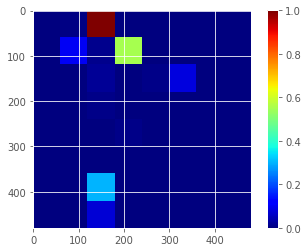

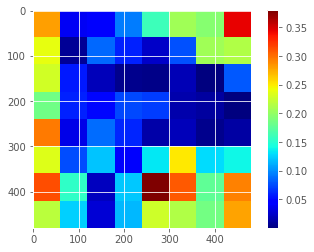

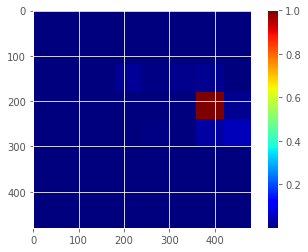

bicycle_2010_003446.jpg
[[0.7605     0.54946667]
 [0.4453     0.53973333]
 [0.4692     0.44213333]
 [0.589      0.57586667]]
sofa 0.1221408
diningtable 0.11030159
aeroplane 0.10289709
bicycle 0.100997545
boat 0.09960598
motorbike 0.09654575
dog 0.09431672
horse 0.092702866
cow 0.09154305
cat 0.08894866
(480, 480, 3)
0.031249992820224302
aeroplane 0.16905265
dog 0.1307297
boat 0.112212464
horse 0.10618137
bicycle 0.09858463
cow 0.08793254
sofa 0.08721434
motorbike 0.08231382
cat 0.07697189
diningtable 0.048806634
(480, 480, 3)
0.031235789319026708
motorbike 0.8031308
bicycle 0.17662069
boat 0.0047381506
diningtable 0.00426885
aeroplane 0.002819429
sofa 0.0027758565
dog 0.0027577279
horse 0.0019511303
cow 0.00075435964
cat 0.00018301592
(480, 480, 3)
0.030326972364711047


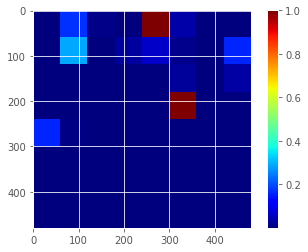

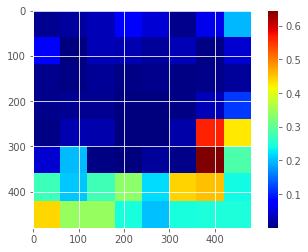

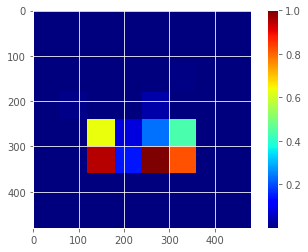


 41%|████      | 253/614 [00:20<02:16,  2.65it/s]

cat_2008_002668.jpg
[[0.5675     0.35780781]
 [0.4639     0.55045045]]
sofa 0.13791034
diningtable 0.131462
cow 0.11067198
horse 0.10590186
boat 0.10253152
dog 0.09808202
motorbike 0.08312016
cat 0.0816394
bicycle 0.07985033
aeroplane 0.06883036
(480, 480, 3)
0.031249994224926095
boat 0.14328499
dog 0.13660696
horse 0.12256449
aeroplane 0.11116343
cow 0.10950575
sofa 0.106813796
cat 0.07319401
diningtable 0.07052059
motorbike 0.065718435
bicycle 0.0606275
(480, 480, 3)
0.031189691783367834
cat 0.97490853
dog 0.008990369
horse 0.006522392
cow 0.0036061965
diningtable 0.0020283794
motorbike 0.0017626436
boat 0.001558064
sofa 0.0003499188
bicycle 0.0001992304
aeroplane 7.4177864e-05
(480, 480, 3)
0.031074238244684693


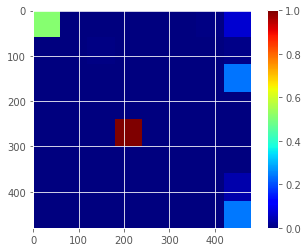

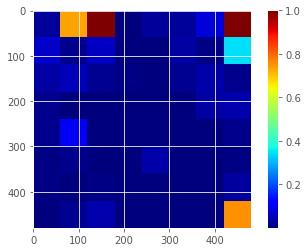

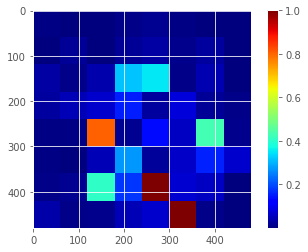


 48%|████▊     | 297/614 [00:20<01:24,  3.74it/s]

cat_2010_001457.jpg
[[0.7008     0.78738739]
 [0.4699     0.54654655]
 [0.424      0.55345345]]
sofa 0.1206791
diningtable 0.104678795
horse 0.10389547
boat 0.09800327
bicycle 0.09787058
cow 0.09729172
cat 0.09712443
dog 0.09597943
aeroplane 0.0951784
motorbike 0.08929879
(480, 480, 3)
0.031249999072464858
boat 0.13983406
dog 0.13482034
horse 0.12081762
aeroplane 0.1154306
cow 0.10889868
sofa 0.1069704
cat 0.07429968
diningtable 0.07046162
motorbike 0.06621813
bicycle 0.062248867
(480, 480, 3)
0.031194965753911674
cat 0.9862461
dog 0.0056367544
horse 0.0026771233
cow 0.0018859976
diningtable 0.0013097731
motorbike 0.0011037155
boat 0.00083533826
sofa 0.00023331208
bicycle 5.6848545e-05
aeroplane 1.4943661e-05
(480, 480, 3)
0.011626416105109172


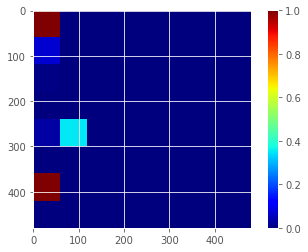

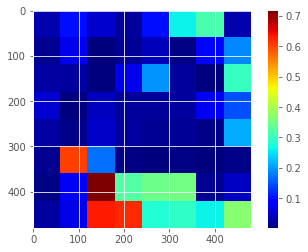

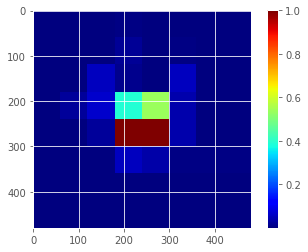

cat_2010_004816.jpg
[[0.4373     0.46586667]
 [0.4844     0.43053333]
 [0.0501     0.00613333]]
sofa 0.1208031
diningtable 0.10193614
horse 0.1014862
bicycle 0.09903654
boat 0.09831122
aeroplane 0.09752061
cow 0.09705425
cat 0.096223824
dog 0.09593151
motorbike 0.091696605
(480, 480, 3)
0.030698551323553324
dog 0.14216168
boat 0.1249812
horse 0.1211635
cow 0.11967125
sofa 0.11648018
aeroplane 0.10298732
diningtable 0.07949367
cat 0.06875905
motorbike 0.064236954
bicycle 0.060065184
(480, 480, 3)
0.03113101703047505
cat 0.5782033
dog 0.30869177
cow 0.062166225
horse 0.026214955
diningtable 0.013206801
sofa 0.005999058
boat 0.003964646
motorbike 0.0010500201
bicycle 0.0002805909
aeroplane 0.00022268444
(480, 480, 3)
0.03042466633701224


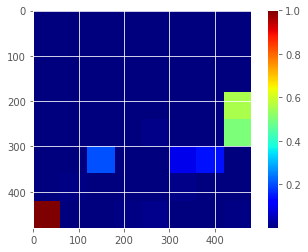

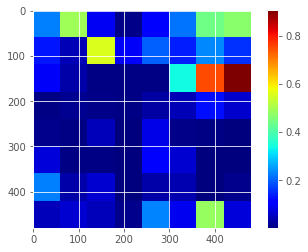

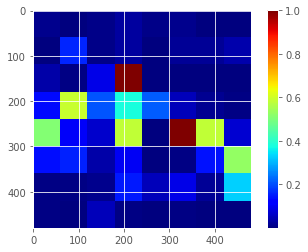

cat_2008_006294.jpg
[[0.2261     0.58490683]
 [0.4521     0.54559006]]
sofa 0.12043025
horse 0.10197262
diningtable 0.101317294
boat 0.09856169
bicycle 0.09818527
aeroplane 0.09766399
cow 0.09759109
cat 0.09654596
dog 0.09648352
motorbike 0.09124829
(480, 480, 3)
0.03124937771153645
dog 0.13936031
boat 0.13722666
horse 0.13616036
cow 0.11770028
sofa 0.105966516
aeroplane 0.09483847
cat 0.074897155
diningtable 0.07382173
motorbike 0.06185471
bicycle 0.058173798
(480, 480, 3)
0.030623012563410157
horse 0.35446247
dog 0.24461699
cat 0.1816332
cow 0.114159204
boat 0.046428856
diningtable 0.027652966
sofa 0.015512374
bicycle 0.008579759
aeroplane 0.004273118
motorbike 0.002681061
(480, 480, 3)
0.031217190811048567


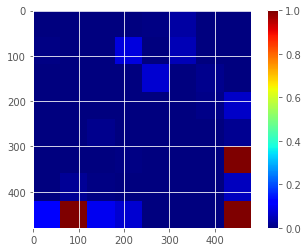

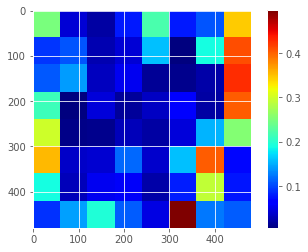

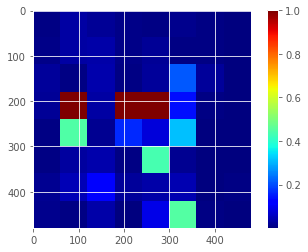

cat_2011_003216.jpg
[[0.576      0.42746667]
 [0.3852     0.6224    ]
 [0.3682     0.65493333]]
sofa 0.12226086
horse 0.11039999
cat 0.10537022
dog 0.105320126
boat 0.09948014
cow 0.09898078
aeroplane 0.09532883
motorbike 0.09034147
diningtable 0.0868592
bicycle 0.085658334
(480, 480, 3)
0.031249996908294966
dog 0.13043267
boat 0.12471401
horse 0.120084964
sofa 0.118083194
cow 0.115350954
aeroplane 0.104493
diningtable 0.079080164
cat 0.07815972
motorbike 0.067309745
bicycle 0.062291574
(480, 480, 3)
0.030940337993342837
cat 0.5485982
horse 0.19824117
cow 0.10263059
dog 0.08138339
diningtable 0.030528495
boat 0.014763876
motorbike 0.009998011
sofa 0.009054753
aeroplane 0.0029591375
bicycle 0.0018424123
(480, 480, 3)
0.030694533591486106


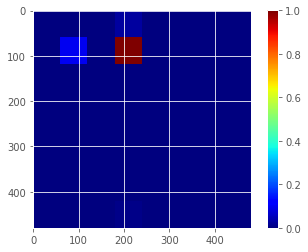

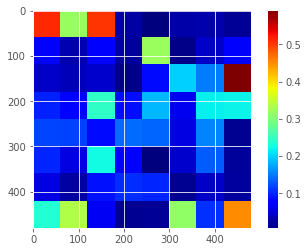

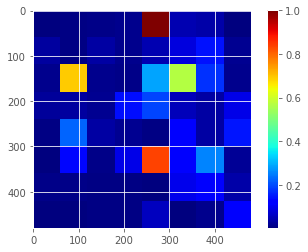

cat_2011_002409.jpg
[[0.1063     0.59714715]
 [0.3719     0.07702703]
 [0.3696     0.6512012 ]]
bicycle 0.15496098
sofa 0.13762358
diningtable 0.13286252
boat 0.11803173
horse 0.11436118
aeroplane 0.11428366
dog 0.06933175
motorbike 0.057546444
cat 0.0514671
cow 0.04953107
(480, 480, 3)
0.0312500014443073
boat 0.14224166
dog 0.12655394
horse 0.12071863
sofa 0.10939208
aeroplane 0.10685552
cow 0.10445789
diningtable 0.07701342
cat 0.07669156
motorbike 0.0686988
bicycle 0.06737653
(480, 480, 3)
0.031227781675994493
cat 0.95164186
dog 0.013043171
horse 0.011415935
boat 0.010684506
diningtable 0.0066573853
cow 0.0032166436
motorbike 0.0020720544
bicycle 0.00053051295
sofa 0.0005003722
aeroplane 0.00023755574
(480, 480, 3)
0.030781770538283126


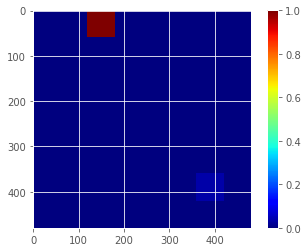

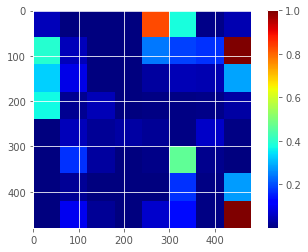

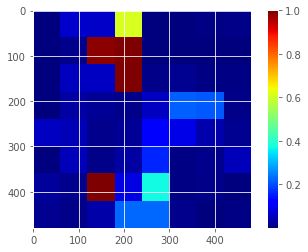


 49%|████▉     | 302/614 [00:23<01:46,  2.93it/s]

cat_2008_002623.jpg
[[0.6427   0.642375]
 [0.1548   0.76575 ]
 [0.432    0.4338  ]]
sofa 0.121420965
diningtable 0.10412721
horse 0.10270455
boat 0.09990314
aeroplane 0.09774546
cow 0.09727759
cat 0.09727378
bicycle 0.095676884
dog 0.0944958
motorbike 0.08937467
(480, 480, 3)
0.031249996275752243
sofa 0.14996377
horse 0.11603779
diningtable 0.1101032
cow 0.110031806
dog 0.107459016
motorbike 0.10289425
cat 0.10137447
bicycle 0.088602886
aeroplane 0.057864677
boat 0.055668164
(480, 480, 3)
0.03094838460401661
cat 0.4134179
dog 0.23421857
cow 0.13029638
horse 0.08342088
diningtable 0.03256272
sofa 0.032479607
boat 0.030103099
motorbike 0.020180203
bicycle 0.014405585
aeroplane 0.00891502
(480, 480, 3)
0.030783904775944393


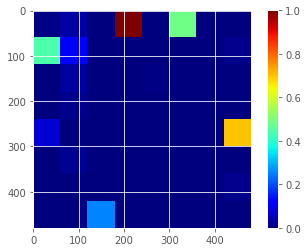

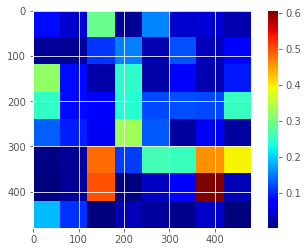

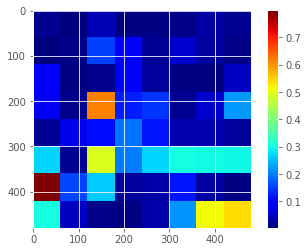

cat_2010_003598.jpg
[[0.5696  0.42532]
 [0.491   0.52584]
 [0.4738  0.5684 ]]
boat 0.38357452
aeroplane 0.15403739
bicycle 0.11779181
horse 0.08211046
motorbike 0.06747951
diningtable 0.060587525
dog 0.05071984
sofa 0.032085437
cow 0.031155268
cat 0.020458207
(480, 480, 3)
0.031236456042550258
boat 0.19309607
aeroplane 0.13129161
horse 0.13102302
bicycle 0.10914295
dog 0.09740691
cow 0.08991239
motorbike 0.07844642
cat 0.06420816
diningtable 0.059032895
sofa 0.046439704
(480, 480, 3)
0.031249994970263748
horse 0.26995206
bicycle 0.17862883
motorbike 0.15043548
dog 0.13911831
cow 0.12840255
boat 0.048299413
diningtable 0.033037685
cat 0.025725948
sofa 0.018560568
aeroplane 0.007839224
(480, 480, 3)
0.030248402626298798


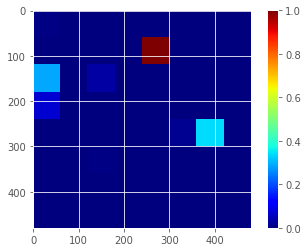

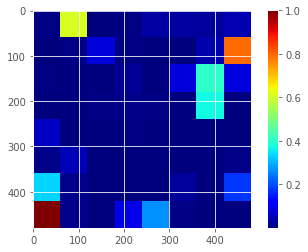

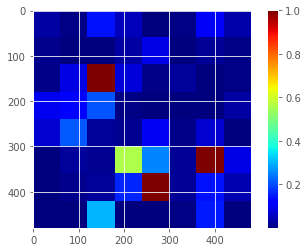

cat_2010_005250.jpg
[[0.2435     0.3352    ]
 [0.4252     0.54786667]
 [0.3101     0.4524    ]]
motorbike 0.150884
cow 0.13949707
dog 0.11601933
aeroplane 0.10504698
bicycle 0.10073519
horse 0.08937195
sofa 0.087814525
cat 0.08396634
boat 0.08091228
diningtable 0.045752343
(480, 480, 3)
0.031249998270877825
boat 0.13895273
dog 0.12726507
horse 0.11846198
aeroplane 0.109547436
sofa 0.109139375
cow 0.105352856
cat 0.07751284
diningtable 0.075940095
motorbike 0.070172
bicycle 0.067655675
(480, 480, 3)
0.031166350700613132
cat 0.9850802
dog 0.0070105577
horse 0.0035117029
cow 0.0014772391
boat 0.0010187163
motorbike 0.00083423103
diningtable 0.0008092927
sofa 0.00017978459
bicycle 6.477871e-05
aeroplane 1.3448938e-05
(480, 480, 3)
0.03061976134085853


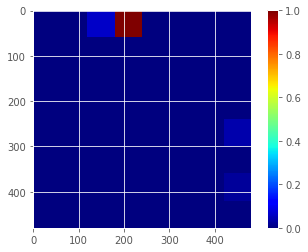

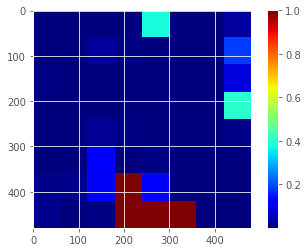

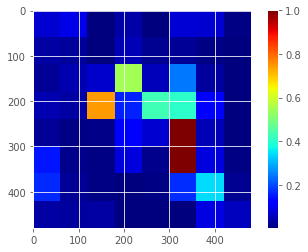

cat_2009_004051.jpg
[[0.7712     0.47486842]
 [0.4426     0.39631579]
 [0.3962     0.40684211]]
sofa 0.12048439
horse 0.101725996
diningtable 0.10162244
bicycle 0.098675884
boat 0.098244086
aeroplane 0.09761737
cow 0.09717944
cat 0.09673713
dog 0.09606898
motorbike 0.09164427
(480, 480, 3)
0.031249998703130964
boat 0.13008407
dog 0.12731858
horse 0.12356027
sofa 0.11056404
aeroplane 0.10632195
cow 0.10507642
diningtable 0.0805449
cat 0.078860596
motorbike 0.0693211
bicycle 0.068348035
(480, 480, 3)
0.03121477825155239
cat 0.9783387
dog 0.0074381814
horse 0.0063107945
cow 0.0024045666
diningtable 0.0018674467
motorbike 0.001524606
boat 0.0014719863
sofa 0.0004683654
bicycle 0.00013063206
aeroplane 4.469176e-05
(480, 480, 3)
0.03113333726514611


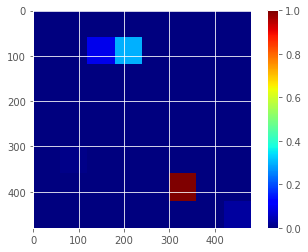

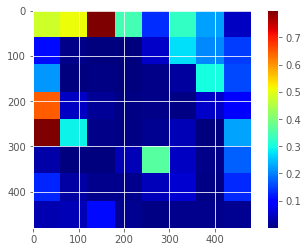

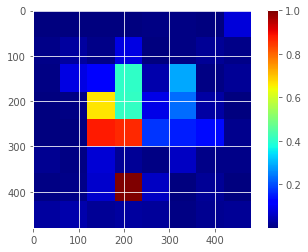


 50%|████▉     | 306/614 [00:25<02:01,  2.54it/s]

cow_2010_003345.jpg
[[0.6177     0.63378378]
 [0.4327     0.67387387]]
sofa 0.118969865
horse 0.10316279
boat 0.102505505
cow 0.099763006
dog 0.09923604
diningtable 0.09918606
aeroplane 0.09815118
bicycle 0.09534778
cat 0.0945284
motorbike 0.089149304
(480, 480, 3)
0.03125000066667788
aeroplane 0.18021777
boat 0.13562566
horse 0.11621228
dog 0.11395807
sofa 0.09986861
cow 0.09951296
cat 0.0704716
bicycle 0.06746213
motorbike 0.062172387
diningtable 0.05449854
(480, 480, 3)
0.03114077645659563
sofa 0.23179184
diningtable 0.12034269
aeroplane 0.11802626
dog 0.114079595
bicycle 0.11253767
boat 0.084417865
horse 0.08117188
motorbike 0.065818556
cow 0.0422757
cat 0.029537903
(480, 480, 3)
0.030674663230001897


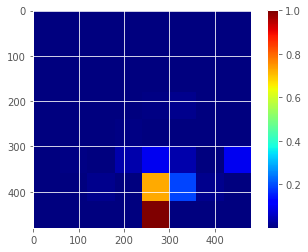

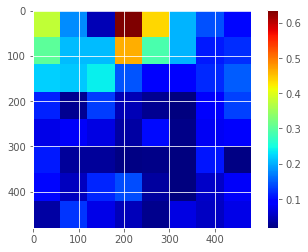

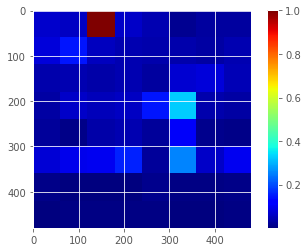


 65%|██████▌   | 402/614 [00:26<00:58,  3.60it/s]

cow_2009_002869.jpg
[[0.2806     0.40734127]
 [0.1724     0.47738095]
 [0.1471     0.43769841]]
boat 0.13526557
aeroplane 0.13156685
diningtable 0.11237433
motorbike 0.10063954
sofa 0.09950256
bicycle 0.09404492
horse 0.08563461
cow 0.08463822
dog 0.079230726
cat 0.07710264
(480, 480, 3)
0.03124999990231501
aeroplane 0.13734712
boat 0.12957788
dog 0.1252533
horse 0.11510439
cow 0.10561226
sofa 0.102686904
cat 0.076336615
bicycle 0.07173265
motorbike 0.06946506
diningtable 0.06688383
(480, 480, 3)
0.030399337545091498
cow 0.5085022
horse 0.30448365
dog 0.11974117
motorbike 0.020521738
sofa 0.018467547
cat 0.0135966875
boat 0.0065251975
diningtable 0.003540221
bicycle 0.002341929
aeroplane 0.0022797105
(480, 480, 3)
0.031246970063989465


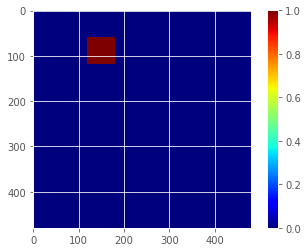

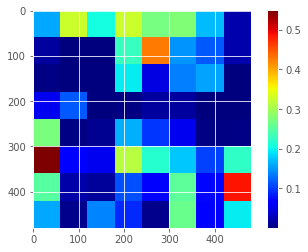

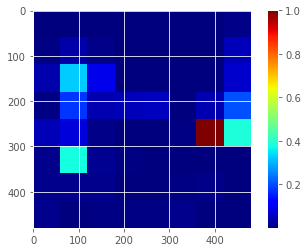

cow_2008_007544.jpg
[[0.6903    0.4205256]
 [0.4553    0.4986168]
 [0.2513    0.53669  ]]
boat 0.1305818
dog 0.12704048
horse 0.11632865
sofa 0.11126127
aeroplane 0.10775485
cow 0.10769818
cat 0.0797654
diningtable 0.078313895
motorbike 0.07183687
bicycle 0.06941867
(480, 480, 3)
0.031240887959197217
cow 0.5753113
dog 0.22649506
horse 0.13750972
sofa 0.026636915
motorbike 0.011326098
cat 0.010176407
aeroplane 0.0058130478
boat 0.003067804
diningtable 0.0030046268
bicycle 0.0006591115
(480, 480, 3)
0.030681629857099324
cow 0.6808041
dog 0.15333115
horse 0.11116509
sofa 0.03192514
motorbike 0.009293033
cat 0.005311163
aeroplane 0.003776748
boat 0.0020313787
diningtable 0.0019559718
bicycle 0.00040624742
(480, 480, 3)
0.031170829575392744


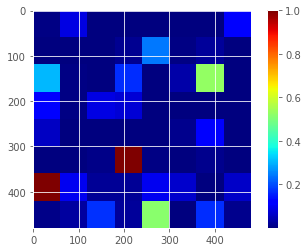

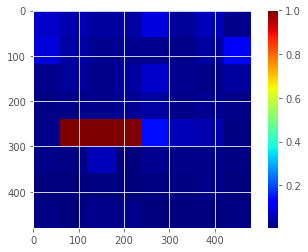

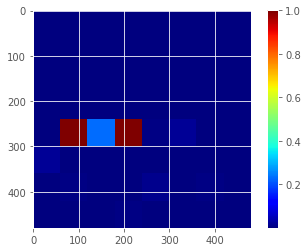

cow_2008_002709.jpg
[[0.5298     0.4939759 ]
 [0.4492     0.51596386]]
boat 0.17637043
bicycle 0.1729231
aeroplane 0.13725847
horse 0.11270342
diningtable 0.11072427
sofa 0.07629931
dog 0.066860974
motorbike 0.05675243
cow 0.04755132
cat 0.042556256
(480, 480, 3)
0.031249950047720448
aeroplane 0.16685788
boat 0.16185543
horse 0.12104088
dog 0.11043088
sofa 0.0897605
cow 0.088659644
bicycle 0.07512079
cat 0.06565139
diningtable 0.063463494
motorbike 0.057159085
(480, 480, 3)
0.031249907284571776
horse 0.6320822
cow 0.15364414
boat 0.090331346
dog 0.032609027
bicycle 0.025494702
diningtable 0.022304451
cat 0.013311754
sofa 0.012243943
motorbike 0.009021708
aeroplane 0.008956624
(480, 480, 3)
0.026548520817868848


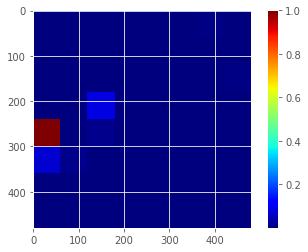

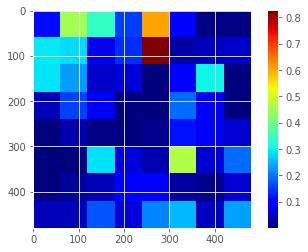

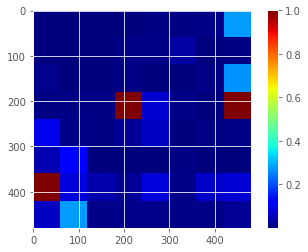

cow_2011_001950.jpg
[[0.629      0.4088    ]
 [0.6278     0.39813333]
 [0.6275     0.4056    ]
 [0.1625     0.34306667]
 [0.1344     0.3728    ]
 [0.6012     0.41493333]]
sofa 0.12073293
diningtable 0.10341533
horse 0.10181371
boat 0.09877377
bicycle 0.09751153
aeroplane 0.09735975
dog 0.09705825
cat 0.096976586
cow 0.09628295
motorbike 0.09007523
(480, 480, 3)
0.03124962785604847
boat 0.1369735
dog 0.13543625
horse 0.11408288
cow 0.1117524
aeroplane 0.10758466
sofa 0.106875576
diningtable 0.07636844
cat 0.076253474
motorbike 0.07063231
bicycle 0.06404054
(480, 480, 3)
0.030944618257535694
cow 0.5160238
horse 0.26063368
dog 0.15404758
cat 0.023377655
sofa 0.018986538
motorbike 0.01034087
boat 0.008949195
diningtable 0.0056815315
aeroplane 0.0012237438
bicycle 0.00073539553
(480, 480, 3)
0.031158866243686134


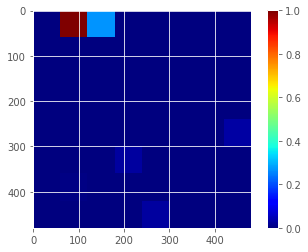

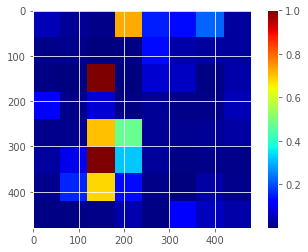

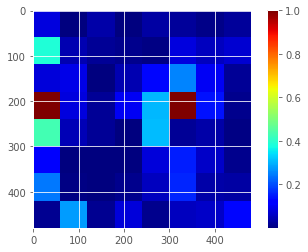

cow_2009_002549.jpg
[[0.6983     0.3498494 ]
 [0.6263     0.47786145]
 [0.111      0.47439759]
 [0.098      0.45150602]]
sofa 0.12048623
cat 0.11995229
horse 0.119354844
cow 0.10597652
dog 0.103940874
diningtable 0.09924027
boat 0.08702355
motorbike 0.08630603
bicycle 0.07982753
aeroplane 0.07789188
(480, 480, 3)
0.031250000920287443
boat 0.13957362
dog 0.13174431
aeroplane 0.13047089
horse 0.12066047
cow 0.10595575
sofa 0.104347475
cat 0.07273344
diningtable 0.06682623
motorbike 0.06453064
bicycle 0.06315721
(480, 480, 3)
0.030118114024986653
cow 0.36522764
horse 0.32150063
dog 0.2079939
cat 0.047975287
sofa 0.020611905
diningtable 0.016289048
boat 0.010087537
motorbike 0.007738389
aeroplane 0.0014573932
bicycle 0.0011183154
(480, 480, 3)
0.026455733392481307


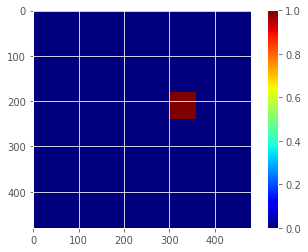

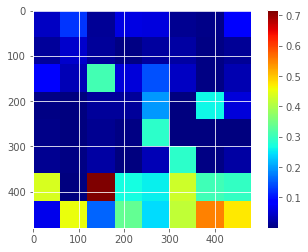

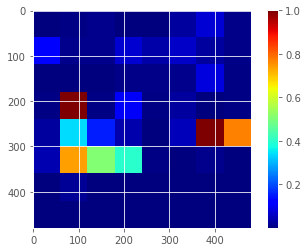

cow_2010_003201.jpg
[[0.3581     0.50146667]
 [0.4109     0.52813333]]
sofa 0.1212482
diningtable 0.10214945
horse 0.10144962
boat 0.099773556
cow 0.09872335
bicycle 0.09858606
dog 0.09731635
cat 0.09521086
aeroplane 0.09483342
motorbike 0.090709195
(480, 480, 3)
0.03124999980276024
aeroplane 0.14823821
boat 0.13151261
dog 0.126743
horse 0.119716674
cow 0.10946085
sofa 0.09988538
cat 0.07357733
motorbike 0.06446804
bicycle 0.06442637
diningtable 0.06197146
(480, 480, 3)
0.030741514852650198
cow 0.43383467
horse 0.3865251
dog 0.117985696
sofa 0.028360581
cat 0.010942112
motorbike 0.008547759
boat 0.005283895
diningtable 0.0049402677
aeroplane 0.0023240703
bicycle 0.0012557809
(480, 480, 3)
0.031249218167701542


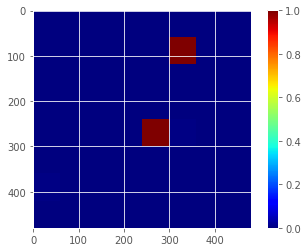

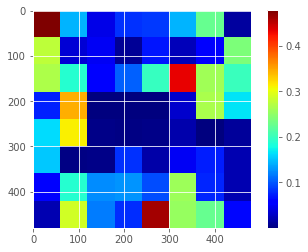

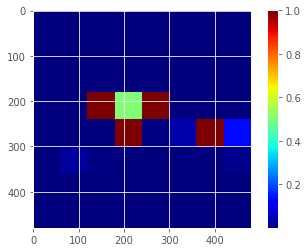

cow_2008_007123.jpg
[[0.5944     0.56893333]
 [0.6732     0.51893333]]
sofa 0.12052059
diningtable 0.1023518
horse 0.101663314
bicycle 0.09945559
boat 0.098519884
aeroplane 0.09776269
cow 0.09661939
cat 0.095916145
dog 0.09569956
motorbike 0.091491014
(480, 480, 3)
0.031249999549801143
boat 0.14608316
dog 0.13426748
horse 0.13292098
cow 0.11234187
sofa 0.10525453
aeroplane 0.09615158
diningtable 0.07776956
cat 0.07232117
bicycle 0.06284103
motorbike 0.060048584
(480, 480, 3)
0.031214424386007522
horse 0.8548622
cow 0.071525514
dog 0.018434767
cat 0.011294537
diningtable 0.010968683
boat 0.0104996925
sofa 0.009793316
bicycle 0.0062340586
motorbike 0.004069637
aeroplane 0.0023175206
(480, 480, 3)
0.031163375094308776


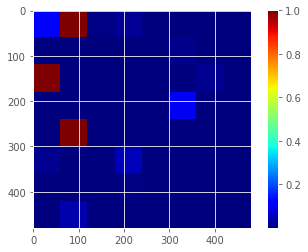

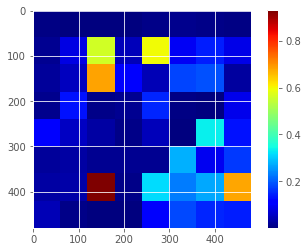

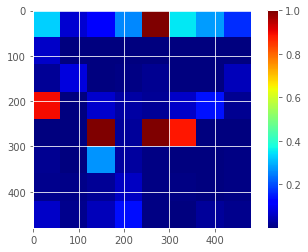

cow_2011_001840.jpg
[[0.4798 0.3652]
 [0.8214 0.6536]]
sofa 0.12038195
diningtable 0.10249405
horse 0.101372994
cat 0.098016225
bicycle 0.09773872
boat 0.09773769
dog 0.097376615
cow 0.097288154
aeroplane 0.09629765
motorbike 0.091295965
(480, 480, 3)
0.031249959525107052
boat 0.14269255
dog 0.13788159
horse 0.12309697
cow 0.11075717
aeroplane 0.10963942
sofa 0.10599705
cat 0.07340792
diningtable 0.07043939
motorbike 0.066080615
bicycle 0.060007285
(480, 480, 3)
0.03124588994012356
horse 0.75180864
cow 0.16388154
dog 0.0256924
cat 0.014358052
boat 0.012011415
sofa 0.010686047
motorbike 0.008800495
diningtable 0.0073756515
bicycle 0.0030655132
aeroplane 0.0023202398
(480, 480, 3)
0.03004189110060196


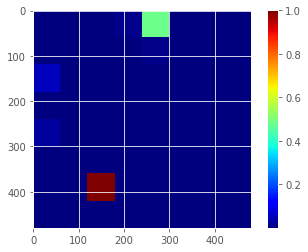

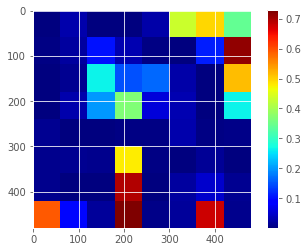

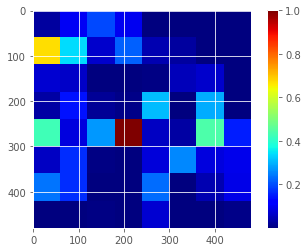


 67%|██████▋   | 410/614 [00:30<01:10,  2.89it/s]

cow_2009_002708.jpg
[[0.5971     0.39504132]
 [0.3996     0.4338843 ]
 [0.5183     0.34848485]]
sofa 0.12010285
diningtable 0.10100804
horse 0.10075478
bicycle 0.09933695
cow 0.09766415
boat 0.09760914
aeroplane 0.09705788
cat 0.0968511
dog 0.096387595
motorbike 0.093227476
(480, 480, 3)
0.031249999684905397
boat 0.1321847
dog 0.13006164
horse 0.119749755
sofa 0.110593505
cow 0.10907279
aeroplane 0.107935004
cat 0.078291886
diningtable 0.07491339
motorbike 0.07067069
bicycle 0.06652667
(480, 480, 3)
0.031169277306617005
dog 0.8217554
cat 0.10104375
cow 0.045438483
horse 0.019940438
motorbike 0.006030742
boat 0.002320299
sofa 0.0022463354
diningtable 0.00059082365
bicycle 0.0004857541
aeroplane 0.00014795164
(480, 480, 3)
0.030983521655912227


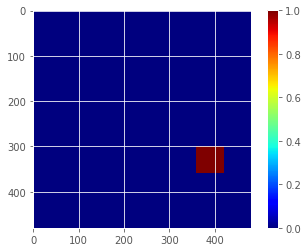

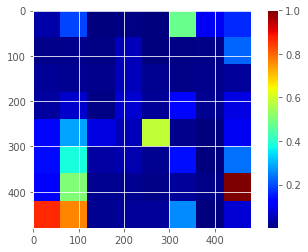

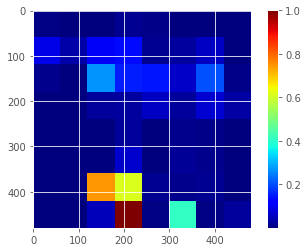


 68%|██████▊   | 416/614 [00:30<00:52,  3.75it/s]

diningtable_2010_002880.jpg
[[0.3556   0.607425]
 [0.6811   0.576675]
 [0.6598   0.7803  ]]
sofa 0.11605461
horse 0.11365745
cat 0.10990193
cow 0.10798115
dog 0.102739125
diningtable 0.098155424
boat 0.09153292
motorbike 0.08891219
bicycle 0.08630764
aeroplane 0.08475754
(480, 480, 3)
0.031249998344918373
boat 0.14648187
dog 0.13140327
aeroplane 0.12325889
horse 0.117608525
sofa 0.10564727
cow 0.102602385
diningtable 0.07179181
cat 0.07076514
motorbike 0.06698251
bicycle 0.06345838
(480, 480, 3)
0.031233853516397403
diningtable 0.8923417
bicycle 0.032035727
sofa 0.031130593
horse 0.013865558
motorbike 0.013151174
dog 0.007431133
boat 0.005563406
cow 0.002434274
cat 0.0012014733
aeroplane 0.0008449395
(480, 480, 3)
0.029234122783464045


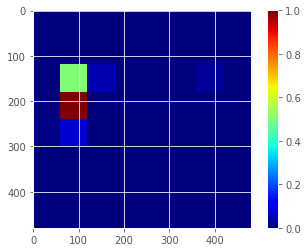

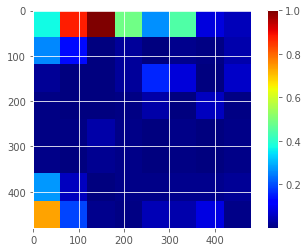

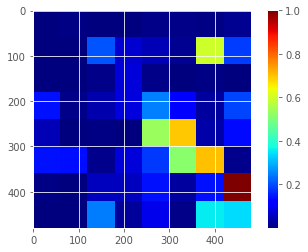


 70%|███████   | 432/614 [00:31<00:35,  5.11it/s]

diningtable_2009_004263.jpg
[[0.5298     0.65545852]
 [0.4868     0.40731441]]
sofa 0.14300428
diningtable 0.116966136
cat 0.11621519
bicycle 0.10029869
boat 0.09483058
horse 0.09332991
motorbike 0.09108573
aeroplane 0.0854836
dog 0.08444378
cow 0.07434218
(480, 480, 3)
0.03124987639749405
dog 0.13222669
boat 0.13128391
horse 0.11903012
cow 0.11115459
sofa 0.11089105
aeroplane 0.107513934
cat 0.077341065
diningtable 0.07625829
motorbike 0.06912051
bicycle 0.06517976
(480, 480, 3)
0.03119975896362348
sofa 0.63300985
diningtable 0.20487477
horse 0.09346308
bicycle 0.026324786
dog 0.017741317
cow 0.01087018
boat 0.006103815
aeroplane 0.0033480998
motorbike 0.0027273514
cat 0.0015367292
(480, 480, 3)
0.0224261111134183


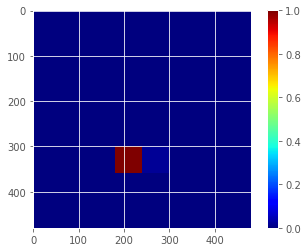

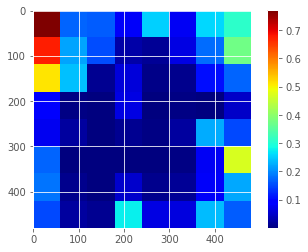

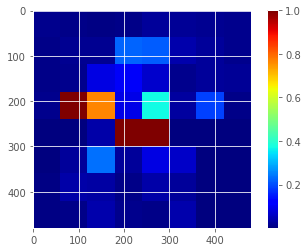

diningtable_2010_005046.jpg
[[0.4604     0.28523308]
 [0.4809     0.13136842]
 [0.4833     0.45028571]
 [0.3408     0.92270677]
 [0.4536     0.8642406 ]]
sofa 0.15864974
diningtable 0.12077951
cat 0.10899346
bicycle 0.10305222
horse 0.096625105
motorbike 0.08976827
boat 0.085481904
dog 0.082909204
aeroplane 0.082403004
cow 0.071337655
(480, 480, 3)
0.02708351917358111
dog 0.14642213
boat 0.13287498
horse 0.122295015
cow 0.11074298
aeroplane 0.10691386
sofa 0.105347194
cat 0.07527459
motorbike 0.06829827
diningtable 0.0663184
bicycle 0.06551258
(480, 480, 3)
0.03123726979660546
diningtable 0.51923746
sofa 0.18616858
bicycle 0.11360105
motorbike 0.06797874
horse 0.042119093
dog 0.026489543
boat 0.019902801
aeroplane 0.014012581
cow 0.0076513025
cat 0.0028389117
(480, 480, 3)
0.030744332111851236


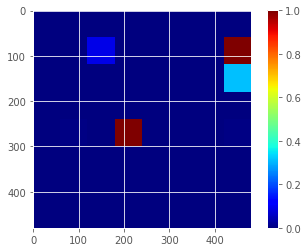

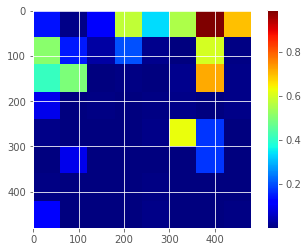

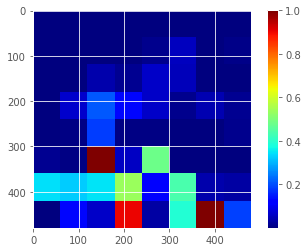

diningtable_2009_000247.jpg
[[0.3589     0.69613333]
 [0.5588     0.54866667]]
sofa 0.11464144
bicycle 0.11087617
boat 0.10862025
aeroplane 0.10465906
horse 0.09835525
diningtable 0.09715424
motorbike 0.096804656
dog 0.095102854
cow 0.08786399
cat 0.08592203
(480, 480, 3)
0.03124965133766764
dog 0.12884435
boat 0.1251582
sofa 0.119396254
horse 0.11912802
cow 0.11447145
aeroplane 0.09906007
diningtable 0.081938244
cat 0.07896378
motorbike 0.06887726
bicycle 0.06416245
(480, 480, 3)
0.031201280694403977
diningtable 0.9080268
sofa 0.049108054
horse 0.015563913
bicycle 0.011926628
motorbike 0.0045335013
dog 0.0041593295
boat 0.003327573
cow 0.0018691163
cat 0.0009859033
aeroplane 0.0004991626
(480, 480, 3)
0.030526970031814926


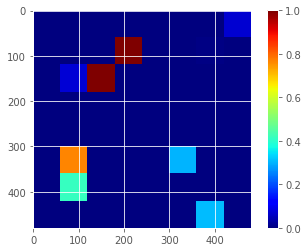

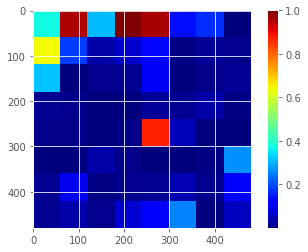

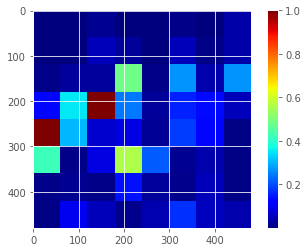

diningtable_2011_002994.jpg
[[0.5835     0.72717718]
 [0.8732     0.75555556]]
boat 0.35381103
bicycle 0.14677204
aeroplane 0.14518702
dog 0.07580665
horse 0.06895551
diningtable 0.061364148
motorbike 0.054028943
cow 0.033918686
sofa 0.03120082
cat 0.028955186
(480, 480, 3)
0.031249834211725627
dog 0.16948536
horse 0.1538941
sofa 0.14384751
cow 0.11917984
diningtable 0.11496212
boat 0.074773625
bicycle 0.07422558
motorbike 0.0537322
cat 0.049807057
aeroplane 0.0460926
(480, 480, 3)
0.031239546667785945
sofa 0.46229595
diningtable 0.399288
horse 0.058634173
dog 0.034214884
bicycle 0.0151147
cow 0.011436643
boat 0.006776691
motorbike 0.006185519
aeroplane 0.0045350976
cat 0.0015183614
(480, 480, 3)
0.0312103855303576


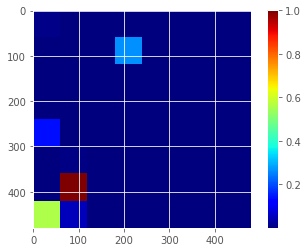

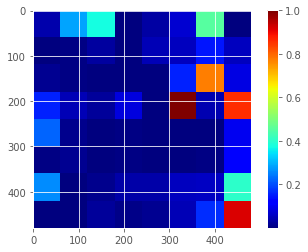

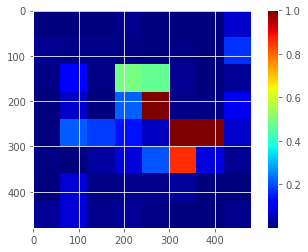


 71%|███████   | 436/614 [00:33<00:52,  3.42it/s]

diningtable_2009_002952.jpg
[[0.2748     0.93906667]
 [0.5174     0.8504    ]
 [0.2598     0.91706667]]
bicycle 0.15205789
boat 0.1336235
aeroplane 0.12431332
horse 0.1151826
diningtable 0.11085975
sofa 0.10459033
dog 0.07330139
motorbike 0.06590489
cow 0.0635739
cat 0.05659242
(480, 480, 3)
0.031249998252320547
dog 0.14188896
boat 0.12847783
horse 0.12419525
cow 0.12007664
sofa 0.11122933
aeroplane 0.101279244
diningtable 0.075102195
cat 0.07267842
motorbike 0.064162865
bicycle 0.060909186
(480, 480, 3)
0.03093131764364898
diningtable 0.30027288
sofa 0.29695678
horse 0.09741251
bicycle 0.05466295
boat 0.051178258
dog 0.05045995
cow 0.04894339
cat 0.042580586
aeroplane 0.03931109
motorbike 0.018221637
(480, 480, 3)
0.031218415019907297


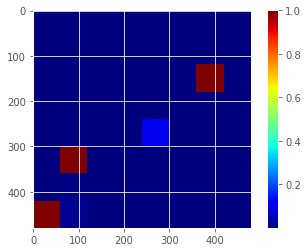

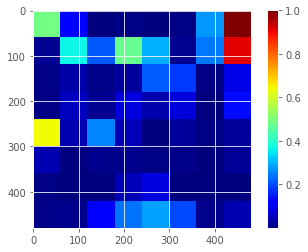

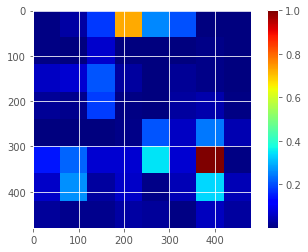

diningtable_2009_003468.jpg
[[0.4116     0.38213333]
 [0.5186     0.72306667]
 [0.7432     0.36466667]]
sofa 0.19737878
bicycle 0.13511862
horse 0.11692253
motorbike 0.11686994
diningtable 0.09890848
dog 0.08802634
cow 0.07047793
aeroplane 0.06725759
cat 0.06209298
boat 0.046946827
(480, 480, 3)
0.03125000167608584
dog 0.13262476
boat 0.118713
aeroplane 0.117469996
sofa 0.11509087
horse 0.11429945
cow 0.11283821
diningtable 0.07802759
bicycle 0.0707031
motorbike 0.070124336
cat 0.07010876
(480, 480, 3)
0.031243309860767732
diningtable 0.9120382
sofa 0.052710682
bicycle 0.011464367
horse 0.009286142
dog 0.0046454538
motorbike 0.004140663
boat 0.0025697693
cow 0.0017881157
cat 0.0009159833
aeroplane 0.0004405889
(480, 480, 3)
0.029305327576821583


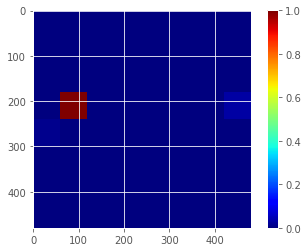

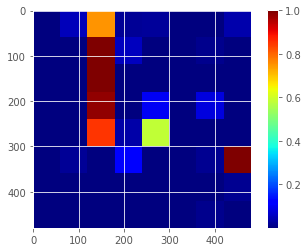

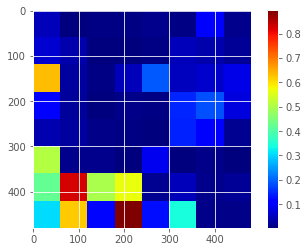

diningtable_2011_002640.jpg
[[0.8198     0.0048048 ]
 [0.5211     0.48588589]
 [0.5036     0.73018018]]
dog 0.14189394
sofa 0.13595362
diningtable 0.13181105
bicycle 0.098873235
motorbike 0.095017575
horse 0.08725043
aeroplane 0.08164034
cow 0.07763543
cat 0.07602466
boat 0.073899694
(480, 480, 3)
0.031249998084502486
dog 0.13664848
boat 0.1339919
horse 0.12044684
cow 0.11441742
sofa 0.11431499
aeroplane 0.10279189
diningtable 0.076128766
cat 0.07427935
motorbike 0.065365665
bicycle 0.061614722
(480, 480, 3)
0.031246711260450866
sofa 0.49903253
diningtable 0.39432922
bicycle 0.028811725
horse 0.02631354
dog 0.013657662
motorbike 0.011324677
aeroplane 0.009357164
boat 0.009091121
cow 0.0070821373
cat 0.0010002394
(480, 480, 3)
0.031222848940160475


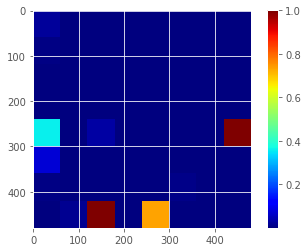

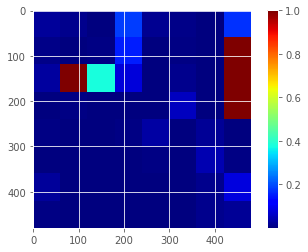

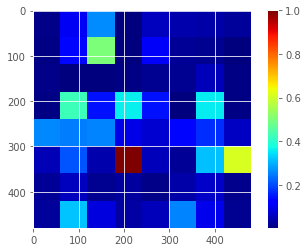


 71%|███████▏  | 439/614 [00:34<01:03,  2.76it/s]

diningtable_2011_002924.jpg
[[0.4943   0.454275]
 [0.5928   0.25305 ]]
sofa 0.14707771
aeroplane 0.1388978
motorbike 0.12907803
bicycle 0.09533231
horse 0.09349429
boat 0.09140436
cow 0.0881983
dog 0.08645278
diningtable 0.080470204
cat 0.04959421
(480, 480, 3)
0.031249982474969674
sofa 0.1824764
diningtable 0.12341227
cow 0.12092044
horse 0.11085454
dog 0.10894974
cat 0.083605714
motorbike 0.074323714
bicycle 0.07362197
boat 0.061900117
aeroplane 0.059935063
(480, 480, 3)
0.031238517682368183
sofa 0.21834762
diningtable 0.14764939
dog 0.12189018
cow 0.10928746
horse 0.103761874
cat 0.08245032
bicycle 0.06920482
motorbike 0.06452052
boat 0.043789603
aeroplane 0.039098173
(480, 480, 3)
0.03080215187947033


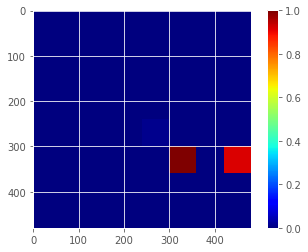

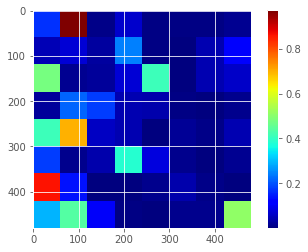

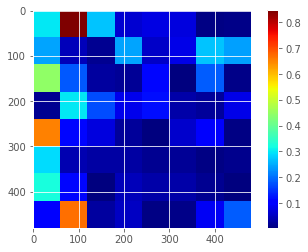

diningtable_2011_000530.jpg
[[0.2951     0.71746667]
 [0.4898     0.5928    ]
 [0.5606     0.4472    ]
 [0.5558     0.4536    ]]
diningtable 0.2467464
sofa 0.19788584
dog 0.11088189
horse 0.07697499
cat 0.07093536
boat 0.06994301
cow 0.06915406
aeroplane 0.061084185
motorbike 0.054525036
bicycle 0.041869212
(480, 480, 3)
0.031249997948407403
dog 0.13264385
boat 0.12427124
horse 0.11744644
sofa 0.11367675
cow 0.1136624
aeroplane 0.10418059
diningtable 0.07973994
cat 0.076727495
motorbike 0.069924474
bicycle 0.067726895
(480, 480, 3)
0.030774769398735025
diningtable 0.4531771
sofa 0.4242248
horse 0.039816774
dog 0.034184363
cow 0.020663096
bicycle 0.009244983
boat 0.0060755047
motorbike 0.005061639
cat 0.004012115
aeroplane 0.0035396782
(480, 480, 3)
0.030403213644603966


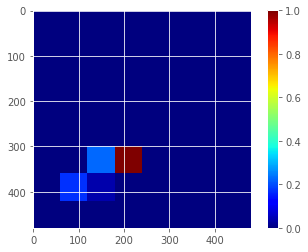

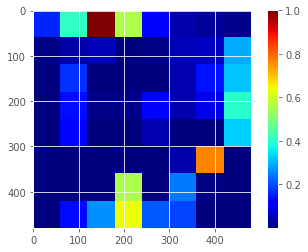

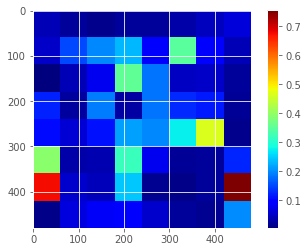


 72%|███████▏  | 441/614 [00:35<01:09,  2.48it/s]

horse_2008_001544.jpg
[[0.2565     0.34653333]
 [0.4928     0.3664    ]]
sofa 0.13527547
cat 0.12064461
diningtable 0.11698363
cow 0.11300651
horse 0.10682855
dog 0.09993087
boat 0.07957028
motorbike 0.07934072
bicycle 0.07531506
aeroplane 0.07310436
(480, 480, 3)
0.031236309489500954
aeroplane 0.17638196
boat 0.13226229
horse 0.11269958
dog 0.10520907
sofa 0.10012485
cow 0.09780953
bicycle 0.075836845
cat 0.075213455
motorbike 0.06642776
diningtable 0.058034603
(480, 480, 3)
0.030711177236838694
horse 0.88722074
cow 0.05296523
dog 0.011459173
boat 0.010828596
cat 0.010319356
bicycle 0.007421187
diningtable 0.006664189
sofa 0.0064755753
motorbike 0.004793734
aeroplane 0.001852283
(480, 480, 3)
0.03115702083925953


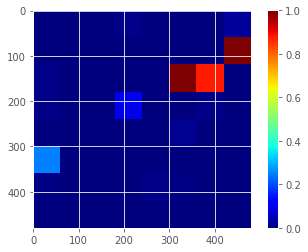

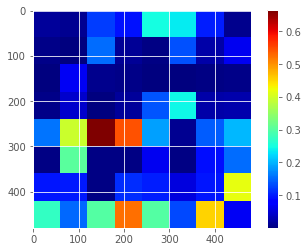

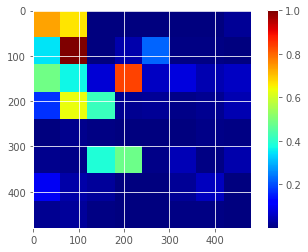


 78%|███████▊  | 479/614 [00:36<00:38,  3.50it/s]

horse_2009_003725.jpg
[[0.5378     0.66561562]
 [0.6977     0.64144144]
 [0.6931     0.70660661]]
sofa 0.12158136
horse 0.10100904
diningtable 0.10062697
bicycle 0.09887117
boat 0.09844929
aeroplane 0.09756929
dog 0.09674522
cow 0.096652105
cat 0.09606705
motorbike 0.09242856
(480, 480, 3)
0.031249997687856843
boat 0.13774875
dog 0.1322432
aeroplane 0.12410438
horse 0.11978405
cow 0.10760707
sofa 0.10550192
cat 0.07415347
diningtable 0.06863274
motorbike 0.066390574
bicycle 0.06383388
(480, 480, 3)
0.030215604662203077
boat 0.34440756
bicycle 0.23012471
motorbike 0.1400604
aeroplane 0.11950667
diningtable 0.081222855
horse 0.041408364
dog 0.017847136
cow 0.012662766
sofa 0.010878956
cat 0.001880543
(480, 480, 3)
0.031239852254429934


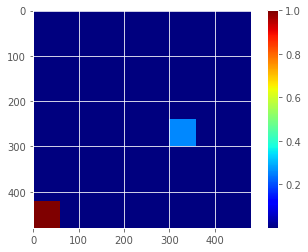

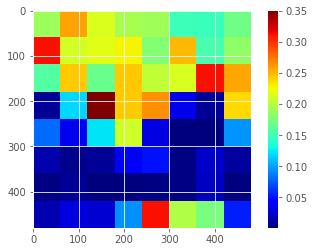

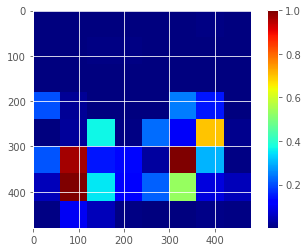

horse_2011_000594.jpg
[[0.7415     0.56426667]
 [0.5196     0.3416    ]
 [0.4891     0.27546667]
 [0.5624     0.37106667]]
sofa 0.12058644
diningtable 0.10202556
horse 0.101590864
bicycle 0.09887129
boat 0.09820886
aeroplane 0.09756654
cow 0.09702131
cat 0.09652416
dog 0.09584979
motorbike 0.091755226
(480, 480, 3)
0.03124999847524268
boat 0.14252865
dog 0.13598697
horse 0.122193664
aeroplane 0.1115057
cow 0.109287515
sofa 0.10691731
cat 0.07360493
diningtable 0.070807114
motorbike 0.06599445
bicycle 0.061173737
(480, 480, 3)
0.031203641222646183
horse 0.85914934
cow 0.07644069
dog 0.019730829
diningtable 0.010233658
sofa 0.009035932
boat 0.008479131
cat 0.008245221
bicycle 0.003876722
motorbike 0.0028852753
aeroplane 0.0019231151
(480, 480, 3)
0.031242920026102183


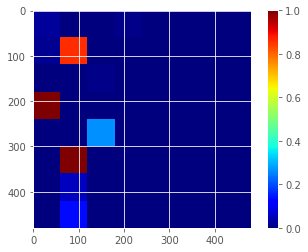

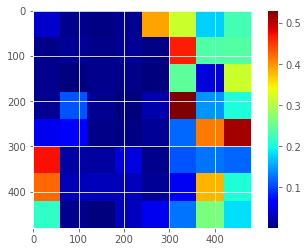

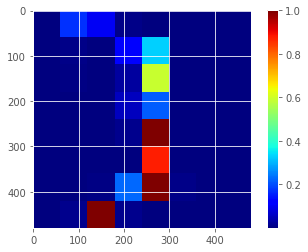

horse_2008_002835.jpg
[[0.302      0.20143198]
 [0.4912     0.23544153]
 [0.577      0.39403341]
 [0.5354     0.36873508]]
diningtable 0.2731526
boat 0.15133607
horse 0.10539833
dog 0.09093678
bicycle 0.08390274
sofa 0.08356994
cat 0.058820672
aeroplane 0.05468362
motorbike 0.054528587
cow 0.043670718
(480, 480, 3)
0.03124999967115524
aeroplane 0.19041108
boat 0.1401017
horse 0.11705613
dog 0.10912336
sofa 0.09715855
cow 0.095367484
bicycle 0.06993486
cat 0.06902597
motorbike 0.05974103
diningtable 0.05207979
(480, 480, 3)
0.03124984879039827
horse 0.8155575
cow 0.087272614
dog 0.05029799
bicycle 0.014696423
boat 0.01005907
sofa 0.0076978086
cat 0.0051510534
diningtable 0.004058209
motorbike 0.0031957612
aeroplane 0.0020136507
(480, 480, 3)
0.03124679046806378


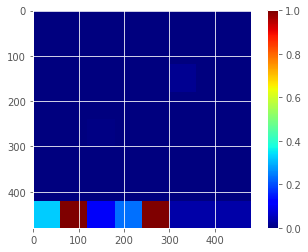

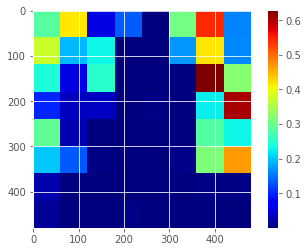

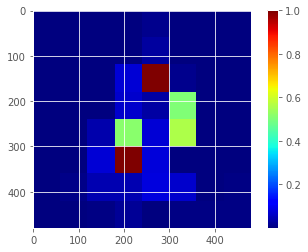

horse_2008_008052.jpg
[[0.3664     0.47655367]
 [0.6871     0.66370056]
 [0.6455     0.62062147]
 [0.6704     0.57485876]
 [0.647      0.61497175]]
sofa 0.1205816
diningtable 0.1017718
horse 0.10174508
bicycle 0.09856714
boat 0.09839755
cow 0.09753963
aeroplane 0.09753178
cat 0.09635898
dog 0.09601695
motorbike 0.091489546
(480, 480, 3)
0.029692549529737773
aeroplane 0.16782756
boat 0.13610637
dog 0.1210823
horse 0.11810811
cow 0.101798125
sofa 0.09969887
cat 0.07000313
bicycle 0.06647477
motorbike 0.062083013
diningtable 0.05681774
(480, 480, 3)
0.031168169124612177
horse 0.57868814
dog 0.23757093
cow 0.108735174
cat 0.02948979
sofa 0.014278549
bicycle 0.01203179
boat 0.008274381
motorbike 0.0051173405
diningtable 0.0043402086
aeroplane 0.0014736835
(480, 480, 3)
0.03124677368140283


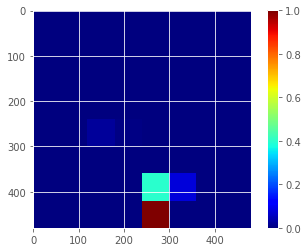

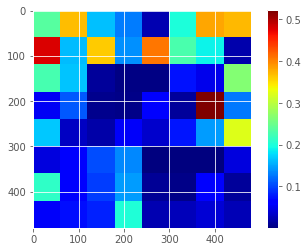

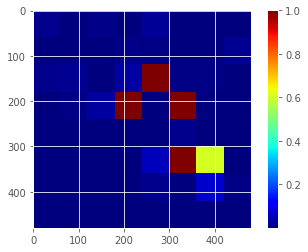


 79%|███████▊  | 483/614 [00:38<00:46,  2.81it/s]

horse_2008_006087.jpg
[[0.3535     0.70533333]
 [0.4265     0.60466667]]
boat 0.19411604
horse 0.14993341
aeroplane 0.12444548
cat 0.11381954
dog 0.111748874
cow 0.093992695
sofa 0.061801534
bicycle 0.06006634
diningtable 0.05307794
motorbike 0.036998156
(480, 480, 3)
0.0004307660527936162
aeroplane 0.15194589
boat 0.13521796
dog 0.1222898
horse 0.117096245
cow 0.104819
sofa 0.09718741
cat 0.0728821
bicycle 0.07055889
motorbike 0.06741781
diningtable 0.06058488
(480, 480, 3)
0.0312498151649643
horse 0.8836554
cow 0.06706952
dog 0.011446719
diningtable 0.008995316
boat 0.0067655486
sofa 0.0059280368
bicycle 0.0054952186
motorbike 0.0050444473
cat 0.0038527467
aeroplane 0.0017469616
(480, 480, 3)
0.03124811368441094


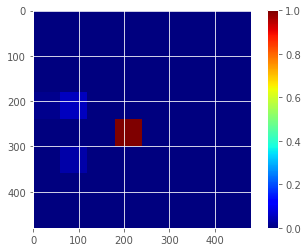

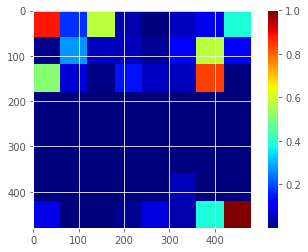

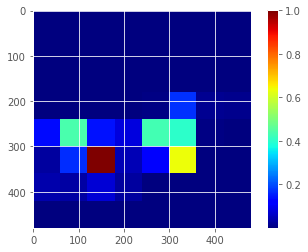

horse_2011_001253.jpg
[[0.6559 0.5369]
 [0.3224 0.3593]
 [0.3403 0.3689]]
sofa 0.1351451
cow 0.12369219
dog 0.11132004
cat 0.109937444
horse 0.10539905
motorbike 0.09779992
diningtable 0.09622239
bicycle 0.07996836
boat 0.07156886
aeroplane 0.0689466
(480, 480, 3)
0.03125000099596926
boat 0.13865894
dog 0.13391337
horse 0.1197276
aeroplane 0.11128115
cow 0.10869646
sofa 0.10757134
cat 0.07584126
diningtable 0.07171163
motorbike 0.068397366
bicycle 0.064200915
(480, 480, 3)
0.031249138938844248
horse 0.70182544
cow 0.16013762
dog 0.059117988
sofa 0.02454827
motorbike 0.014223266
cat 0.012179248
boat 0.009819601
diningtable 0.009769194
bicycle 0.0050929375
aeroplane 0.0032863917
(480, 480, 3)
0.031242197209905953


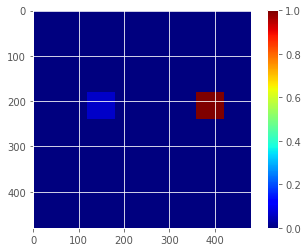

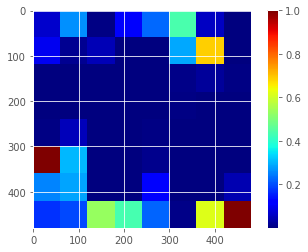

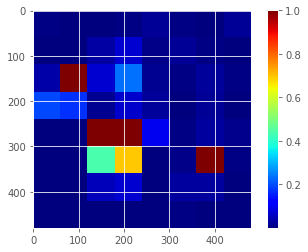

horse_2008_004396.jpg
[[0.5539  0.40965]
 [0.4364  0.4146 ]]
bicycle 0.12928773
boat 0.1259149
aeroplane 0.11529393
horse 0.111879505
diningtable 0.11079725
sofa 0.10914445
dog 0.08214009
cow 0.075395525
motorbike 0.070709795
cat 0.06943677
(480, 480, 3)
0.031249663696856184
boat 0.14618793
dog 0.13380733
horse 0.12187493
aeroplane 0.11418902
cow 0.10652035
sofa 0.10584451
cat 0.07303231
diningtable 0.07109535
motorbike 0.06535594
bicycle 0.06209235
(480, 480, 3)
0.030855157935505417
horse 0.49658567
cow 0.17292152
dog 0.13085791
cat 0.05141301
sofa 0.051396713
diningtable 0.042022757
boat 0.026356155
bicycle 0.012533979
motorbike 0.010445944
aeroplane 0.005466371
(480, 480, 3)
0.03122392897410009


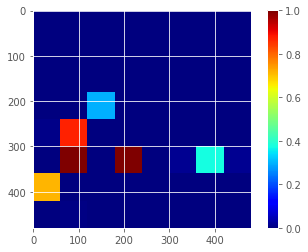

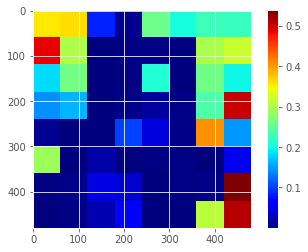

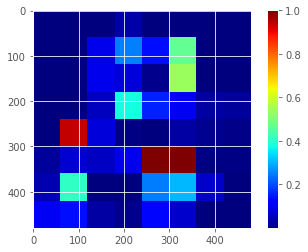


 79%|███████▉  | 486/614 [00:39<00:50,  2.52it/s]

horse_2008_008232.jpg
[[0.7007     0.67213333]
 [0.5223     0.4944    ]
 [0.6178     0.5132    ]
 [0.8918     0.54306667]]
sofa 0.11786951
aeroplane 0.1016203
boat 0.09979703
cat 0.09962779
dog 0.09954577
horse 0.099445194
cow 0.09848502
diningtable 0.09796864
bicycle 0.09527347
motorbike 0.090367295
(480, 480, 3)
0.03124980881433437
aeroplane 0.19159997
boat 0.1374516
horse 0.11565991
dog 0.11026586
sofa 0.09680206
cow 0.09631883
bicycle 0.07021882
cat 0.06974524
motorbike 0.061089307
diningtable 0.05084832
(480, 480, 3)
0.030451499657146996
horse 0.46931523
cow 0.2570814
dog 0.20372573
cat 0.017453518
sofa 0.0165013
motorbike 0.013118598
boat 0.009479856
diningtable 0.0062747733
bicycle 0.004529111
aeroplane 0.0025205102
(480, 480, 3)
0.030963513543952104


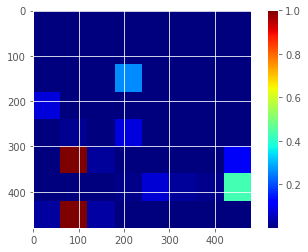

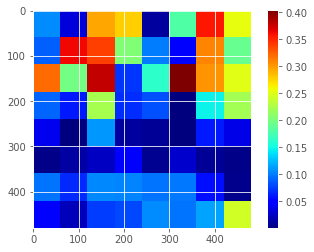

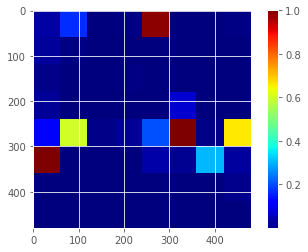

horse_2009_002182.jpg
[[0.4562     0.59177019]
 [0.7238     0.30170807]
 [0.7791     0.24906832]
 [0.7698     0.27826087]]
sofa 0.12098441
horse 0.11022045
dog 0.10899639
cat 0.107710786
cow 0.10012125
boat 0.097451754
motorbike 0.09458131
aeroplane 0.09355753
bicycle 0.084496535
diningtable 0.081879504
(480, 480, 3)
0.031249122674845142
boat 0.14242499
dog 0.13069741
horse 0.12658992
cow 0.10484754
aeroplane 0.1030597
sofa 0.09990381
bicycle 0.0750187
diningtable 0.07487059
cat 0.07399672
motorbike 0.06859055
(480, 480, 3)
0.031118532707523627
bicycle 0.9119743
horse 0.026826382
motorbike 0.02114906
diningtable 0.019936092
dog 0.0070767263
sofa 0.0060216053
boat 0.005002518
cow 0.0008709171
aeroplane 0.0007834428
cat 0.00035887564
(480, 480, 3)
0.03086466276590727


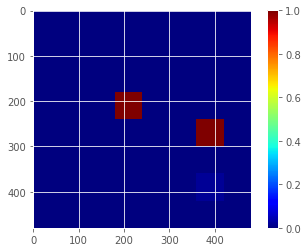

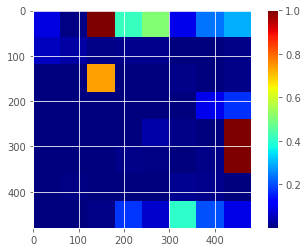

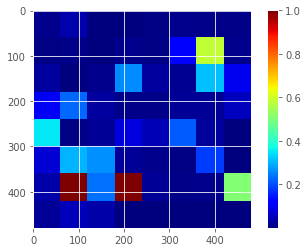


 79%|███████▉  | 488/614 [00:40<00:53,  2.34it/s]

motorbike_2008_004554.jpg
[[0.5683     0.51756757]
 [0.6281     0.43108108]]
sofa 0.12041995
horse 0.10117637
diningtable 0.100889474
bicycle 0.100200064
boat 0.09757354
cow 0.09724497
aeroplane 0.09717754
dog 0.09667801
cat 0.09610857
motorbike 0.09253147
(480, 480, 3)
0.031249999488621266
boat 0.13804771
dog 0.13361192
aeroplane 0.12961698
horse 0.12068593
cow 0.10611926
sofa 0.10395055
cat 0.07316138
diningtable 0.065942116
motorbike 0.06523235
bicycle 0.063631825
(480, 480, 3)
0.03102908472232002
motorbike 0.6476883
bicycle 0.32690316
diningtable 0.008605966
aeroplane 0.005034256
dog 0.0028951056
sofa 0.0028296162
boat 0.0028041413
horse 0.0025862898
cow 0.00057619746
cat 7.696324e-05
(480, 480, 3)
0.031245433531921663


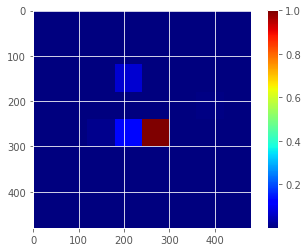

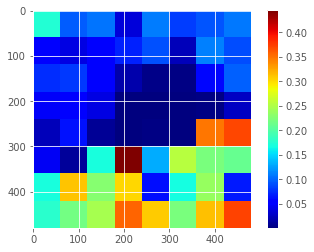

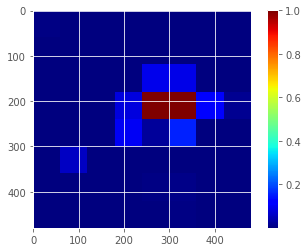


 86%|████████▌ | 527/614 [00:41<00:26,  3.30it/s]

motorbike_2008_006152.jpg
[[0.5463     0.34386667]
 [0.3591     0.646     ]
 [0.2695     0.72773333]
 [0.5728     0.37506667]]
sofa 0.16547003
diningtable 0.13576706
cow 0.12437566
horse 0.12056082
boat 0.105199754
dog 0.10281384
aeroplane 0.07584659
motorbike 0.06337568
bicycle 0.05585568
cat 0.050734777
(480, 480, 3)
0.031247544081267762
boat 0.21432568
aeroplane 0.19367296
horse 0.120475024
bicycle 0.09621674
dog 0.07942624
sofa 0.077445455
diningtable 0.06404967
cow 0.062128164
cat 0.050516106
motorbike 0.04174388
(480, 480, 3)
0.031249001929037235
horse 0.7988855
cow 0.07179899
dog 0.034441937
bicycle 0.022012658
diningtable 0.019174097
sofa 0.018103981
motorbike 0.015921984
boat 0.00976253
cat 0.00675097
aeroplane 0.0031473592
(480, 480, 3)
0.03097162610472992


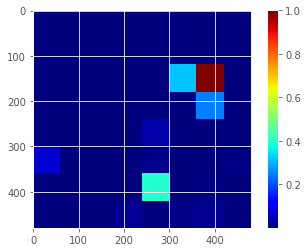

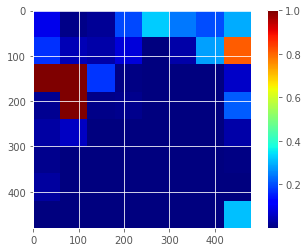

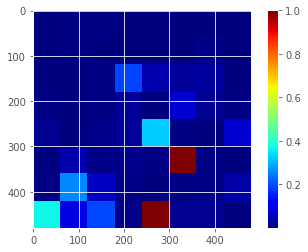

motorbike_2008_004729.jpg
[[0.4466     0.43746667]
 [0.8411     0.51933333]
 [0.7246     0.4992    ]]
sofa 0.1206183
diningtable 0.10396881
horse 0.10177203
boat 0.09864439
bicycle 0.09841866
cow 0.09801103
dog 0.09696195
cat 0.09681907
aeroplane 0.09331731
motorbike 0.091468476
(480, 480, 3)
0.031245888561305522
dog 0.15489803
aeroplane 0.1522304
boat 0.11560219
horse 0.104926325
bicycle 0.101580404
cow 0.09116868
motorbike 0.083242886
sofa 0.07724009
cat 0.07343954
diningtable 0.045671497
(480, 480, 3)
0.031241015370483183
motorbike 0.903062
bicycle 0.08369433
aeroplane 0.0040716734
boat 0.0040604067
dog 0.0017338919
diningtable 0.001637471
horse 0.00060678826
sofa 0.00055354025
cow 0.00047636672
cat 0.000103546634
(480, 480, 3)
0.031183098320922475


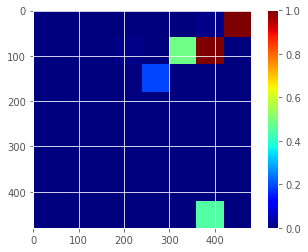

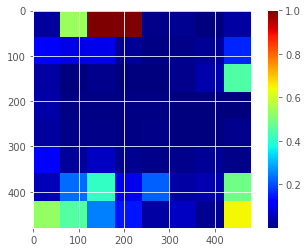

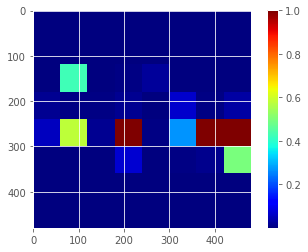

motorbike_2008_005790.jpg
[[0.4811     0.74059701]
 [0.4529     0.61910448]]
boat 0.17340136
bicycle 0.1361748
aeroplane 0.1272198
motorbike 0.11354505
dog 0.09771866
horse 0.09363942
diningtable 0.07083359
sofa 0.06615986
cow 0.06075896
cat 0.06054848
(480, 480, 3)
0.029403985309444262
boat 0.13839754
dog 0.13122602
aeroplane 0.13119312
horse 0.11603851
sofa 0.10540587
cow 0.10372279
cat 0.071891
diningtable 0.06959469
motorbike 0.06757337
bicycle 0.0649571
(480, 480, 3)
0.029757864642220966
motorbike 0.9153644
bicycle 0.04109108
dog 0.010156456
boat 0.009488692
aeroplane 0.007859967
diningtable 0.0053690313
cow 0.0042352485
horse 0.002699641
sofa 0.0024776654
cat 0.0012577998
(480, 480, 3)
0.03119544638076377


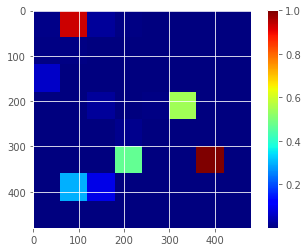

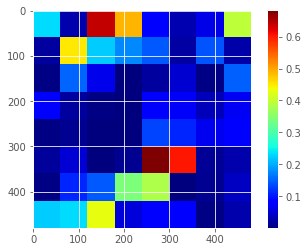

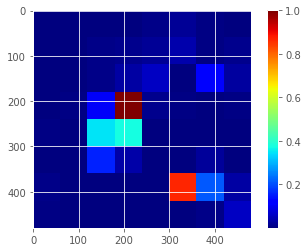


 86%|████████▋ | 530/614 [00:42<00:30,  2.78it/s]

motorbike_2008_003323.jpg
[[0.4062     0.75933333]
 [0.5417     0.56373333]]
sofa 0.12057113
diningtable 0.10214213
horse 0.101502195
bicycle 0.09884723
boat 0.09802507
aeroplane 0.09748259
cow 0.09704167
cat 0.09668933
dog 0.09603299
motorbike 0.09166567
(480, 480, 3)
0.031168446446302824
boat 0.13945507
dog 0.1359236
horse 0.12122341
aeroplane 0.113263294
cow 0.109636344
sofa 0.10753626
cat 0.0736712
diningtable 0.07098699
motorbike 0.06622589
bicycle 0.06207796
(480, 480, 3)
0.031227623642735125
motorbike 0.87693703
bicycle 0.07341544
diningtable 0.014683662
boat 0.014075614
aeroplane 0.007398313
dog 0.0070780036
sofa 0.0036427062
horse 0.0013359907
cow 0.0009414241
cat 0.0004917958
(480, 480, 3)
0.029941402333953704


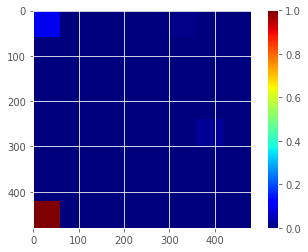

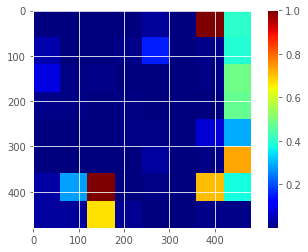

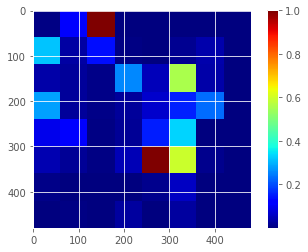

motorbike_2008_008288.jpg
[[0.7025     0.44836795]
 [0.4728     0.43382789]]
boat 0.14263336
sofa 0.13398455
bicycle 0.119723774
horse 0.11119801
diningtable 0.106799275
aeroplane 0.10000837
dog 0.08982787
cow 0.077819735
motorbike 0.06185288
cat 0.05615215
(480, 480, 3)
0.031249998530333514
dog 0.13515112
sofa 0.118799224
aeroplane 0.11865107
cow 0.106967546
horse 0.105616696
boat 0.10365559
diningtable 0.08869531
bicycle 0.08280983
motorbike 0.0823347
cat 0.05731893
(480, 480, 3)
0.03123153797076128
motorbike 0.89150953
bicycle 0.0901805
aeroplane 0.006598586
boat 0.006557871
diningtable 0.0025308477
dog 0.0011568946
horse 0.0005330182
sofa 0.00040498775
cow 0.0003917109
cat 0.00013604478
(480, 480, 3)
0.030380146686894705


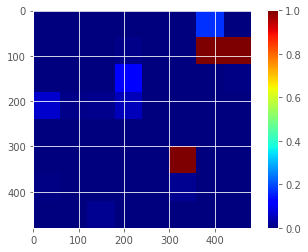

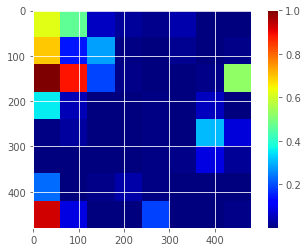

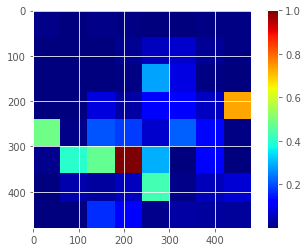

motorbike_2009_004338.jpg
[[0.4279     0.63363363]
 [0.5455     0.5518018 ]]
aeroplane 0.3262186
boat 0.29652652
bicycle 0.19443542
motorbike 0.08160396
horse 0.028010584
dog 0.025851756
diningtable 0.018613232
cat 0.016293399
cow 0.006588301
sofa 0.005858236
(480, 480, 3)
0.031249823578595282
aeroplane 0.21278632
boat 0.16229871
dog 0.091603115
sofa 0.08926653
horse 0.08824339
bicycle 0.08386716
motorbike 0.0791986
cow 0.071834944
diningtable 0.064610995
cat 0.056290217
(480, 480, 3)
0.031249984734213435
motorbike 0.9437806
bicycle 0.044364765
aeroplane 0.0047248425
boat 0.0040007806
dog 0.00088350417
diningtable 0.0007966646
horse 0.0005466935
sofa 0.00045504255
cow 0.0003798187
cat 6.721515e-05
(480, 480, 3)
0.03122454797797758


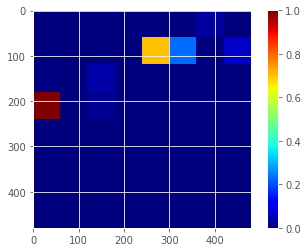

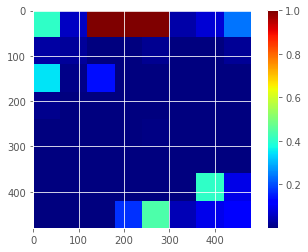

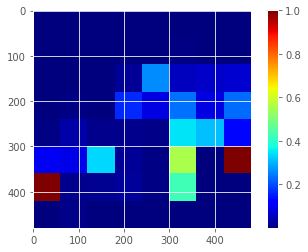


 87%|████████▋ | 533/614 [00:44<00:33,  2.44it/s]

motorbike_2009_000074.jpg
[[0.4092     0.48438438]
 [0.528      0.31756757]]
motorbike 0.14774434
bicycle 0.134833
aeroplane 0.12929983
boat 0.12197986
horse 0.10586022
cow 0.08968483
dog 0.077648774
diningtable 0.065558515
cat 0.06476467
sofa 0.06262593
(480, 480, 3)
0.031249139283101864
dog 0.13888916
boat 0.1256031
horse 0.1198305
cow 0.11546013
sofa 0.11141044
aeroplane 0.11041688
diningtable 0.07643942
cat 0.069118805
motorbike 0.06758491
bicycle 0.065246634
(480, 480, 3)
0.031248215941687363
motorbike 0.9388151
bicycle 0.04647443
aeroplane 0.0047211405
dog 0.0036297883
boat 0.0030131445
diningtable 0.0010399077
horse 0.00085359474
sofa 0.00071081496
cow 0.00061481126
cat 0.0001273035
(480, 480, 3)
0.022855106722573737


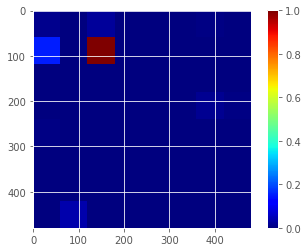

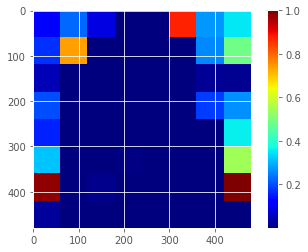

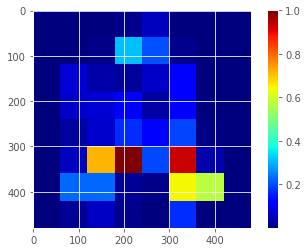

motorbike_2011_002252.jpg
[[0.5533     0.61291291]
 [0.4945     0.2548048 ]
 [0.5605     0.55645646]]
cat 0.11332643
horse 0.10892943
dog 0.106995985
cow 0.10543803
sofa 0.105413094
diningtable 0.10071212
boat 0.09991515
motorbike 0.09422532
bicycle 0.08902758
aeroplane 0.076016925
(480, 480, 3)
0.03124999485165303
sofa 0.14312293
dog 0.121466614
horse 0.108741924
aeroplane 0.10559557
diningtable 0.101734355
cow 0.09666504
bicycle 0.09459312
boat 0.087805554
motorbike 0.081777945
cat 0.058496952
(480, 480, 3)
0.03122180598779778
motorbike 0.84667313
bicycle 0.094811045
boat 0.01728687
diningtable 0.01617331
aeroplane 0.011980856
sofa 0.0051523787
dog 0.004603115
horse 0.0019805625
cow 0.0009220859
cat 0.00041667235
(480, 480, 3)
0.03073948083238065


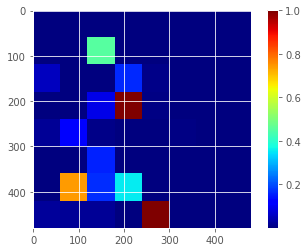

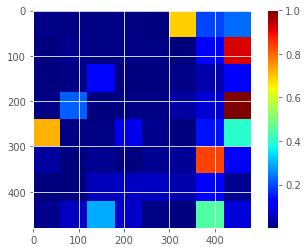

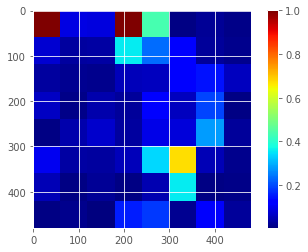


 87%|████████▋ | 535/614 [00:45<00:34,  2.30it/s]

motorbike_2009_004207.jpg
[[0.714      0.9644    ]
 [0.4948     0.56226667]
 [0.6129     0.6192    ]
 [0.6773     0.82533333]]
sofa 0.16242266
diningtable 0.11327354
bicycle 0.10798039
horse 0.09485551
cat 0.09271164
boat 0.091050334
dog 0.09049287
motorbike 0.08688123
aeroplane 0.08342154
cow 0.07691027
(480, 480, 3)
0.031249998220657806
sofa 0.28434294
diningtable 0.1498739
dog 0.11261276
cow 0.095273525
horse 0.09120859
bicycle 0.06876933
motorbike 0.056667384
boat 0.050141353
aeroplane 0.049508877
cat 0.04160135
(480, 480, 3)
0.03122479631861097
motorbike 0.8314791
bicycle 0.11575573
aeroplane 0.021545654
boat 0.015904069
diningtable 0.0072669247
sofa 0.004183747
dog 0.0015975895
horse 0.0014847468
cow 0.00061511964
cat 0.00016732945
(480, 480, 3)
0.031038687493150974


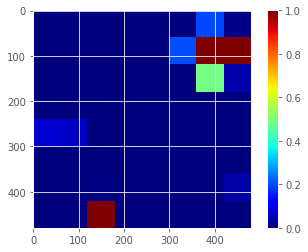

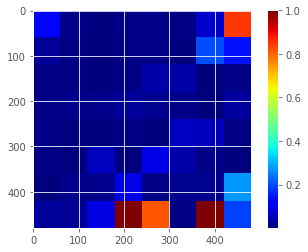

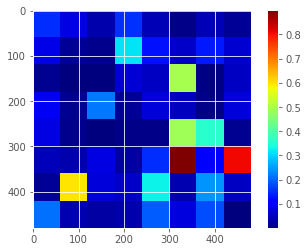


 87%|████████▋ | 537/614 [00:45<00:29,  2.64it/s]

sofa_2009_001376.jpg
[[0.4069     0.4444    ]
 [0.355      0.47253333]
 [0.9635     0.0176    ]]
sofa 0.12026558
diningtable 0.102010585
horse 0.100536525
boat 0.09949172
bicycle 0.098652735
cat 0.09802247
aeroplane 0.0971235
cow 0.09670717
dog 0.09556184
motorbike 0.0916278
(480, 480, 3)
0.031218294393627766
boat 0.13145676
dog 0.12890403
sofa 0.12050861
horse 0.11497546
cow 0.113668
aeroplane 0.101478934
diningtable 0.079461046
cat 0.07572472
motorbike 0.068027176
bicycle 0.06579529
(480, 480, 3)
0.03110090372410923
sofa 0.6871572
diningtable 0.09526032
horse 0.08128723
dog 0.044392116
cow 0.03126182
bicycle 0.026441846
aeroplane 0.010543285
motorbike 0.010268054
boat 0.0076349564
cat 0.005753126
(480, 480, 3)
0.02985774927856255


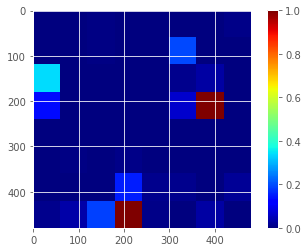

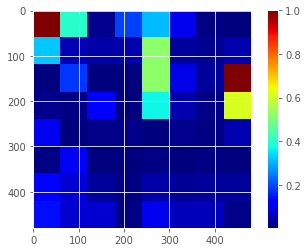

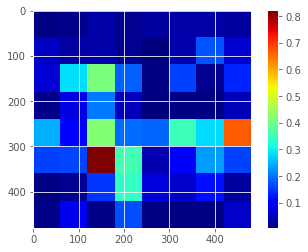


 94%|█████████▍| 577/614 [00:46<00:09,  3.72it/s]

sofa_2010_001189.jpg
[[0.652      0.81693333]
 [0.6802     0.79373333]]
sofa 0.120320216
diningtable 0.101412654
horse 0.100369394
aeroplane 0.09910494
boat 0.098088145
cow 0.097623445
cat 0.0974151
bicycle 0.09729572
dog 0.09692042
motorbike 0.0914499
(480, 480, 3)
0.031249503063318536
dog 0.13875526
boat 0.12583598
horse 0.118987195
cow 0.115441605
sofa 0.11257634
aeroplane 0.11103588
diningtable 0.07717819
cat 0.06824853
motorbike 0.0671025
bicycle 0.06483846
(480, 480, 3)
0.02980199513729076
sofa 0.7305803
diningtable 0.1190504
horse 0.07330877
cow 0.024032831
dog 0.019648664
bicycle 0.0155936945
boat 0.0058549736
aeroplane 0.0047794464
cat 0.003621045
motorbike 0.003529942
(480, 480, 3)
0.03124748167050484


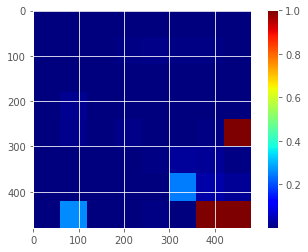

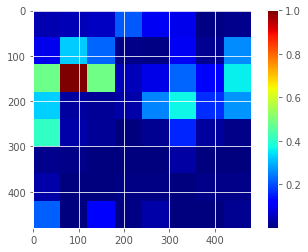

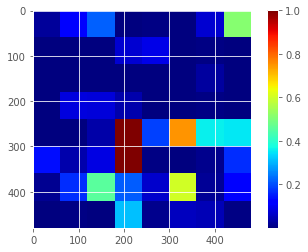

sofa_2011_000820.jpg
[[0.0497  0.2523 ]
 [0.6176  0.51555]
 [0.429   0.4389 ]]
sofa 0.36086148
diningtable 0.12292826
horse 0.10502071
dog 0.08494034
cow 0.08291369
aeroplane 0.057057723
boat 0.05091564
bicycle 0.048088346
cat 0.043841545
motorbike 0.0434323
(480, 480, 3)
0.03124998075348433
boat 0.13265367
dog 0.12897436
aeroplane 0.120131515
horse 0.11777608
cow 0.10763658
sofa 0.10728994
cat 0.0773142
diningtable 0.07261378
motorbike 0.06862144
bicycle 0.066988446
(480, 480, 3)
0.030597889585965987
horse 0.31302357
dog 0.24150988
sofa 0.1624507
cow 0.14388363
cat 0.057285562
diningtable 0.034505952
boat 0.031393263
aeroplane 0.01071615
bicycle 0.0039026558
motorbike 0.0013286327
(480, 480, 3)
0.030787052535401926


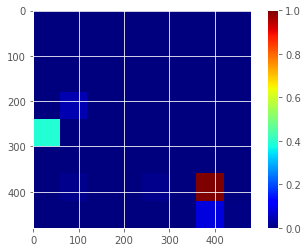

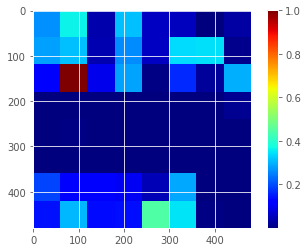

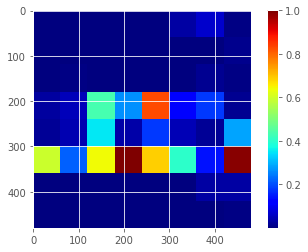

sofa_2010_001763.jpg
[[0.3472     0.49283582]
 [0.6431     0.46208955]]
sofa 0.1415183
diningtable 0.1241409
cat 0.11142124
dog 0.09623393
horse 0.09595772
bicycle 0.09284445
boat 0.0897417
motorbike 0.088025585
aeroplane 0.08131143
cow 0.07880481
(480, 480, 3)
0.031249718344609465
boat 0.13991284
dog 0.13157947
horse 0.119875185
aeroplane 0.10929849
sofa 0.10910311
cow 0.107420266
cat 0.075714506
diningtable 0.07435519
motorbike 0.06827914
bicycle 0.06446177
(480, 480, 3)
0.031181387287375628
sofa 0.6756338
diningtable 0.19614892
dog 0.05800932
horse 0.037133384
cow 0.013707592
bicycle 0.008121488
cat 0.0039913403
boat 0.0026366056
motorbike 0.0025102897
aeroplane 0.0021072587
(480, 480, 3)
0.02895768985331415


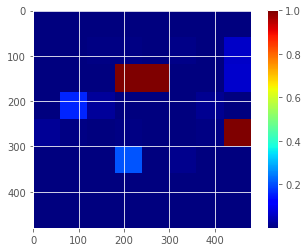

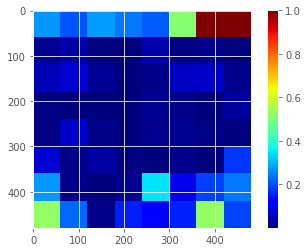

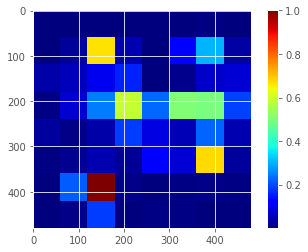

sofa_2009_003656.jpg
[[0.9959     0.34906667]
 [0.6293     0.6876    ]
 [0.6233     0.33906667]
 [0.6301     0.19333333]]
sofa 0.12055323
diningtable 0.10199817
horse 0.10153465
bicycle 0.09891391
boat 0.09816619
aeroplane 0.09753577
cow 0.09703355
cat 0.09655771
dog 0.09585139
motorbike 0.0918554
(480, 480, 3)
0.031249999525562434
boat 0.15041085
dog 0.12927532
horse 0.118760996
aeroplane 0.112758204
sofa 0.10610491
cow 0.1024389
diningtable 0.07631739
cat 0.07152274
motorbike 0.06739436
bicycle 0.06501633
(480, 480, 3)
0.029750917803653465
bicycle 0.3132478
diningtable 0.18173054
boat 0.1699951
horse 0.097234845
aeroplane 0.06820316
motorbike 0.06776796
sofa 0.060767967
dog 0.018723967
cow 0.018129658
cat 0.004198958
(480, 480, 3)
0.03112572910868039


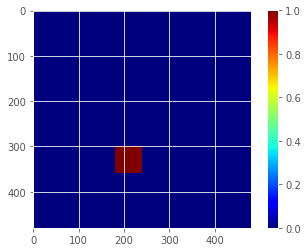

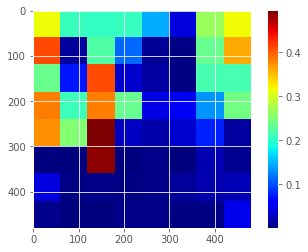

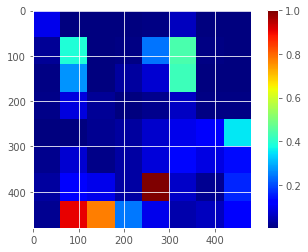


 95%|█████████▍| 581/614 [00:48<00:11,  2.92it/s]

sofa_2011_002752.jpg
[[0.5235     0.68413333]
 [0.3592     0.9704    ]
 [0.5755     0.40253333]]
sofa 0.12636672
diningtable 0.104679346
bicycle 0.10065724
horse 0.099292904
cat 0.097962596
aeroplane 0.096587755
boat 0.09655828
dog 0.094253175
motorbike 0.09247996
cow 0.09116201
(480, 480, 3)
0.031249999399067443
boat 0.13323486
dog 0.1311397
horse 0.12133151
cow 0.11162875
sofa 0.110925436
aeroplane 0.1043446
diningtable 0.07763397
cat 0.07704773
motorbike 0.06719679
bicycle 0.065516636
(480, 480, 3)
0.031097879401158934
sofa 0.7391271
diningtable 0.14343625
horse 0.07076009
bicycle 0.01208579
dog 0.01207682
cow 0.011904756
boat 0.0045998124
aeroplane 0.0032715125
motorbike 0.0017767051
cat 0.0009612067
(480, 480, 3)
0.030934408667235402


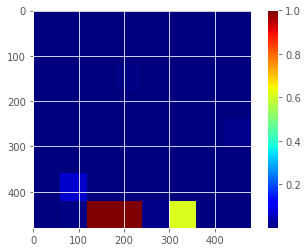

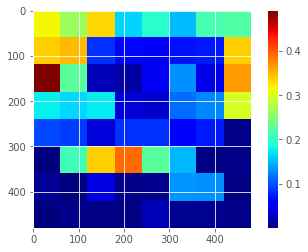

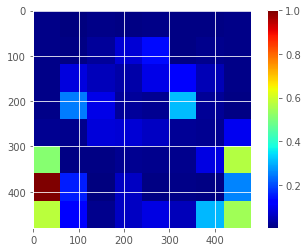

sofa_2009_004588.jpg
[[0.6501     0.78412463]
 [0.5427     0.56142433]]
sofa 0.12056708
diningtable 0.10202133
horse 0.10153438
bicycle 0.09889663
boat 0.098158896
aeroplane 0.0974689
cow 0.09705482
cat 0.09657633
dog 0.09586832
motorbike 0.09185326
(480, 480, 3)
0.03124999977004852
dog 0.1312264
boat 0.12363023
horse 0.121711165
sofa 0.121367
cow 0.11822918
aeroplane 0.10130642
diningtable 0.08091771
cat 0.076648094
motorbike 0.06505282
bicycle 0.059910964
(480, 480, 3)
0.031148086932375918
sofa 0.36494708
diningtable 0.18611422
dog 0.14073521
cow 0.07711376
horse 0.07576567
bicycle 0.04603847
motorbike 0.036631115
cat 0.031571265
boat 0.022984672
aeroplane 0.018098611
(480, 480, 3)
0.03123348902079215


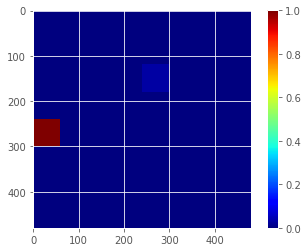

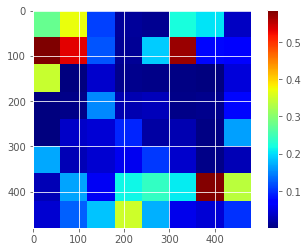

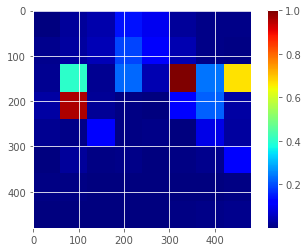

sofa_2010_003804.jpg
[[0.4757 0.78  ]
 [0.6093 0.7224]]
sofa 0.12058147
horse 0.101711504
diningtable 0.1014766
boat 0.0986456
bicycle 0.098460376
aeroplane 0.09773943
cow 0.09732647
dog 0.0962822
cat 0.09623623
motorbike 0.09154007
(480, 480, 3)
0.030967979490775906
boat 0.13701117
dog 0.13554755
horse 0.12039201
aeroplane 0.11631751
cow 0.10903027
sofa 0.107098654
cat 0.07504687
diningtable 0.069656804
motorbike 0.06663527
bicycle 0.063263826
(480, 480, 3)
0.03121857195174016
horse 0.18819901
boat 0.1581615
sofa 0.12205397
dog 0.12160424
diningtable 0.11901461
aeroplane 0.106630065
bicycle 0.10273072
cow 0.046134442
motorbike 0.025382377
cat 0.010089043
(480, 480, 3)
0.031226265670881048


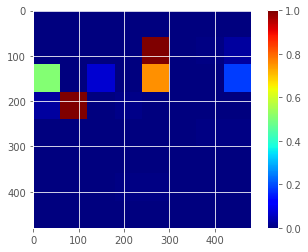

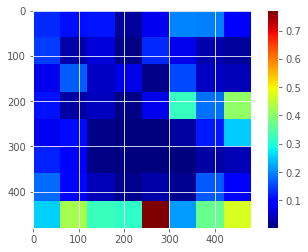

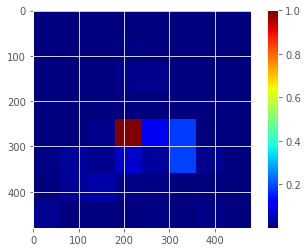


 95%|█████████▌| 584/614 [00:49<00:11,  2.58it/s]

sofa_2009_000939.jpg
[[0.5089     0.70465465]
 [0.1302     0.77882883]]
dog 0.14215535
cat 0.122164115
diningtable 0.116079666
sofa 0.109936535
boat 0.09669941
horse 0.09646097
cow 0.090791196
motorbike 0.07786263
aeroplane 0.07744979
bicycle 0.07040025
(480, 480, 3)
0.031249952418289113
dog 0.13585222
boat 0.13028306
horse 0.11669665
sofa 0.114447884
cow 0.11380123
aeroplane 0.104008034
diningtable 0.07775108
cat 0.07332667
motorbike 0.06791356
bicycle 0.06591958
(480, 480, 3)
0.031242957391498294
sofa 0.51180875
diningtable 0.3394323
horse 0.04952346
dog 0.039314
bicycle 0.025224123
cow 0.014008708
motorbike 0.008607348
boat 0.0043641515
aeroplane 0.0039795777
cat 0.0037375477
(480, 480, 3)
0.03118196047762467


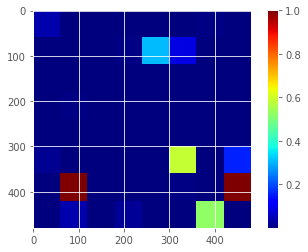

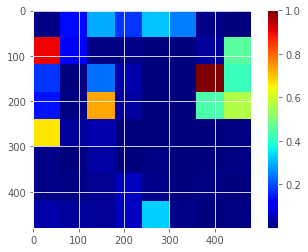

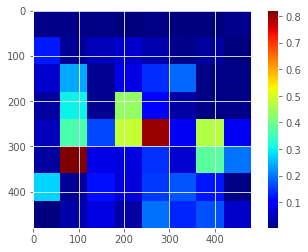

sofa_2009_000926.jpg
[[0.4143     0.3344    ]
 [0.6301     0.55306667]
 [0.8944     0.60066667]]
sofa 0.21350639
diningtable 0.14749166
horse 0.12486838
cat 0.09826139
cow 0.094743006
dog 0.0906839
aeroplane 0.06250437
motorbike 0.060516275
boat 0.05791323
bicycle 0.049511347
(480, 480, 3)
0.031249720762047253
dog 0.13293281
boat 0.12173724
horse 0.11741392
sofa 0.11572912
cow 0.1148529
aeroplane 0.10710994
diningtable 0.08041782
cat 0.07290656
motorbike 0.06953218
bicycle 0.067367464
(480, 480, 3)
0.03124916211205142
sofa 0.5068174
diningtable 0.41946653
horse 0.027907537
dog 0.017900974
bicycle 0.014214489
cow 0.005978121
motorbike 0.0028391606
boat 0.0023494912
cat 0.0016461844
aeroplane 0.00088017574
(480, 480, 3)
0.02938361127689859


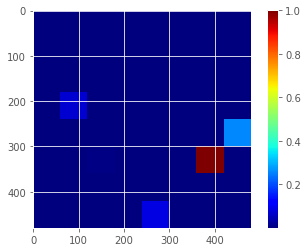

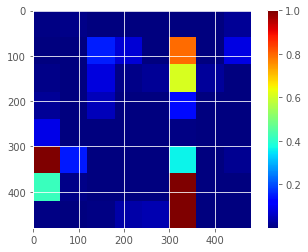

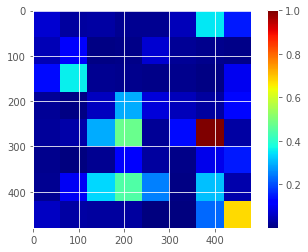


100%|██████████| 614/614 [00:50<00:00, 12.04it/s]

In [65]:
def pearson(a, b):
    return scipy.stats.pearsonr(a.reshape(-1,), b.reshape(-1,))[0]

class_name = 'aeroplane'
class_id = name_to_class_dict[class_name]
class_mask = np.argmax(y_test, axis=1) == class_id

# class_images = images_test[class_mask]
# class_test_proba = test_proba_[class_mask]
# class_proba_list = probabilities_list_[class_mask,:,:]
# class_atts = atts_[class_mask,:,:]
# class_true_atts = prior_attentions_test[class_mask]

class_images = images_test
class_test_proba = test_proba_
class_proba_list = probabilities_list_
class_atts = atts_
class_true_atts = prior_attentions_test

print(class_proba_list.shape)
rescale = IMG_SIZE / SMALLER_IMG_SIZE

image_n = 7
# image_name = np.array(test_ids)[class_mask][image_n]
image_name = np.array(test_ids)[image_n]

results = {}
def construct_res(att_human_steps, att_computer_steps, ground_truth_heatmap, heatmap, proba_res_list):
    assert type(proba_res) == list
    
    ah, bh, ch = att_human_steps
    ac, bc, cc = att_computer_steps
    
    def get_hm_dict(gt, hm):
        return{
            'hm': hm,
            'pcc': pearson(np.abs(hm), gt)
        }
    def get_att_dict(h, c):
        return{
            'computer': c,
            'human': h
        }
    return {
        'avg_heatmap': get_hm_dict(ground_truth_heatmap, heatmap),
        'attention_vis':{
            'a': get_att_dict(ah, ac),
            'b': get_att_dict(bh, bc),
            'c': get_att_dict(ch, cc)
        },
        'prob_res':{
            'a': proba_res_list[0],
            'b': proba_res_list[1],
            'c': proba_res_list[2]
        }
    }

from tqdm import tqdm
for image_n in tqdm(list(range(images_test.shape[0]))[:]):
    image_name = np.array(test_ids)[image_n]
    image_class = image_name.split('_')[0]
    if counter_dict[image_class] > 9:
        continue
        
    counter_dict[image_class] += 1
    
    print(image_name)
    print(name_to_fix_test[image_name])
    
    ground_truth_heatmap = human_heatmaps[image_name]
    
    att_results = []
    overlay_results = []
    proba_res_list = []
    att_human_steps = []
    att_computer_steps = []
    for t in range(atts_.shape[1]):
        image = class_images[image_n]
        proba_res = class_proba_list[image_n,t,:]
    #     print(proba_res)
    #     print(class_to_name_dict[np.argmax(proba_res)])
        proba_res = [(i, proba) for i, proba in enumerate(proba_res)]
        proba_res.sort(key= lambda pair: pair[1], reverse=True)
    #     print(proba_res)
        for i, proba in enumerate(proba_res):
            print(class_to_name_dict[proba[0]], proba[1])
        proba_res_list.append(proba_res)

        if rescale != 1:
            chosen_img = np.array(utils.normalize(skimage.transform.rescale(image.copy(), rescale))) * 500
        else:
            chosen_img = image.copy()
        print(chosen_img.shape)

        chosen_attention = class_atts[image_n,t,:]
        chosen_true_attention = class_true_atts[image_n,t,:]
        print(np.mean(np.abs(chosen_attention - chosen_true_attention)))

        result, att = get_attention_result(chosen_img, chosen_attention, T, IMG_SIZE, PATCH_WIDTH, scale=8, gauss_sigma=None)
#         plt.imshow(result)
#         plt.grid(False)
#         plt.show()
        att_human_steps.append(np.asarray(result, dtype=np.float16))

        att_results.append(att)

        result, att = get_attention_result(chosen_img, chosen_true_attention, T, IMG_SIZE, PATCH_WIDTH, scale=8, gauss_sigma=None)
        att_computer_steps.append(np.asarray(result, dtype=np.float16))
#         plt.imshow(result)
#         plt.grid(False)
#         plt.show()

#         plt.bar(range(atts_.shape[2]), chosen_attention)
#         plt.show()

    for hm in att_results:
        plt.imshow(hm[:,:,0], cmap='jet')
        plt.colorbar()
        plt.show()

#     plt.imshow(np.mean(att_results, axis=0)[:,:,0], cmap='jet')
    heatmap = np.mean(att_results, axis=0)[:,:,0]
    heatmap = skimage.transform.resize(heatmap, output_shape=(224,224))
    heatmap = np.asarray(heatmap, dtype=np.float16)
#     plt.colorbar()
#     plt.show()
    
    results[image_name] = construct_res(att_human_steps, att_computer_steps, 
                 human_heatmaps[image_name], heatmap, proba_res_list)

#     plt.imshow(utils.normalize(image))
#     plt.grid(False)
#     plt.show()

In [66]:
images_test.shape[0]

614

In [67]:
def save_object(obj, path):
    with open(path, 'wb') as f:
        np.savez(f, obj)   
        
def load_object(path):
    with open(path, 'rb') as f:
        ret_di = np.load(f)
    return ret_di

utils.save_object(results, 'soft_att_results.pkl')
utils.save_object(class_to_name_dict, 'soft_classmap.pkl')

In [68]:
hm_test = utils.load_object('soft_att_results.pkl')
class_map = utils.load_object('soft_classmap.pkl')

In [76]:
def overlay_heatmap(org_img, heatmap, gauss_sigma=None, thresh=None, normalize=False, absolute=False):
    img = org_img/255
    if absolute:
        heatmap = np.abs(heatmap)
    
    if thresh:
        heatmap[heatmap < thresh] = 0
    
    if normalize:
        heatmap = utils.normalize(heatmap)
        
#     print(np.min(heatmap), np.max(heatmap))
    if gauss_sigma is not None:
        heatmap = scipy.ndimage.filters.gaussian_filter(heatmap, sigma=gauss_sigma)
    
    if not normalize:
        heatmap = heatmap / 40
    
    heatmap_jet = plt.imshow(heatmap, cmap='jet')
    
    if normalize:
        pass
    else:
        if absolute:
            plt.clim(0,1)
        else:
            plt.clim(-1,1)
    
    colorbar = plt.colorbar()
#     print(colorbar)
#     plt.show()
    
    heatmap_jet.write_png('heatmap.png')
    heatmap_jet_ld = scipy.misc.imread('heatmap.png')
    heatmap_jet_ld = heatmap_jet_ld/ 255
    alpha = 0.5
    

    out_img = np.zeros(img.shape,dtype=img.dtype)
    out_img[:,:,0] = alpha*img[:,:,0] + (1-alpha)* heatmap_jet_ld[:,:,0]
    out_img[:,:,1] = alpha*img[:,:,1] + (1-alpha)* heatmap_jet_ld[:,:,1]
    out_img[:,:,2] = alpha*img[:,:,2] + (1-alpha)* heatmap_jet_ld[:,:,2]

    return out_img, colorbar

def print_proba_results(proba_res, class_to_name_dict):
    for key, value in proba_res.items():
        print(key)
        for i, proba in enumerate(value):
            print(class_to_name_dict[proba[0]], proba[1])

name = list(hm_test.keys())[1]

keys_to_vis = ['avg_heatmap']

def visualize(name, heatmap_results_list, class_map):    
    hm_results = heatmap_results_list[name]
    print("Prediction results:")
    print_proba_results(hm_results['prob_res'], class_map)
    
    for key in keys_to_vis:
        hm_result = hm_results[key]
        img, colorbar = overlay_heatmap(hm_results['image'], hm_result['hm'], 
                                        normalize=(key == 'ground_truth'), absolute=True)
        plt.imshow(img, cmap='jet')
        # plt.colorbar()
        frame1 = plt.gca()
        frame1.axes.xaxis.set_ticks([])
        frame1.axes.yaxis.set_ticks([])
        plt.show()
        if key == 'first_prob':
            print("Prediction:", inv_class_map[hm_results['prob_res'][0][0]])
        elif key == 'second_prob':
            print("Prediction:", inv_class_map[hm_results['prob_res'][1][0]])
        elif key == 'correct':
            for res in hm_results['prob_res']:
                class_n, prob = res
                if inv_class_map[class_n] == name.split('_')[0]:
                    print("Prediction:", inv_class_map[class_n])
        
        print("Perason correlation with ground truth:", hm_result['pcc'])
    
visualize(name, hm_test, class_map)

Prediction results:
a
sofa 0.120653816
horse 0.10175295
diningtable 0.10169232
bicycle 0.09856464
boat 0.09821884
aeroplane 0.09736609
cow 0.09716684
cat 0.09679294
dog 0.0961012
motorbike 0.09169041
b
dog 0.12956104
sofa 0.1227167
boat 0.12205834
horse 0.121937424
cow 0.11842498
aeroplane 0.10065684
diningtable 0.08196125
cat 0.077993974
motorbike 0.065157324
bicycle 0.05953217
c
cat 0.67189634
dog 0.26952815
cow 0.0273471
horse 0.022087788
diningtable 0.0037564728
sofa 0.002374566
boat 0.002049806
motorbike 0.00067645276
bicycle 0.0001841455
aeroplane 9.915589e-05


KeyError: 'image'

In [ ]:
y_pred_proba = test_proba_

y_pred = np.argmax(y_pred_proba, axis=1)

y_test_argmax = np.argmax(y_test, axis=1)

y_test_argmax.shape



plt.figure(figsize=(12,12))
fig = plot_confusion_matrix(y_test_argmax, y_pred, class_names, normalize=True)

In [ ]:
class_proba_list.shape

In [ ]:
# files_list = [glob.glob(os.path.join(main_path, '%s*' %class_)) for class_ in class_names]

# ids_ = []
# final_files_list = []
# labels = []
# for label, files in enumerate(files_list):
#     one_list = []
#     for file in files:
#         id_ = ''.join(file.split('/')[-1].split('.')[0].split('_')[1:])
#         if id_ not in ids_:
#             one_list.append(file)
#             ids_.append(id_)
#             labels.append(label)
#     final_files_list.append(one_list)
    

# files_dict = {class_name.replace('*', ''): class_files for class_name, class_files in zip(class_names, final_files_list)}